<a href="https://colab.research.google.com/github/JaceHo/CS-Notes/blob/master/lk99_proof.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# `noise_step` demo
```
> looks inside
> its mnist
```
I would love to try training a transformer, but the perturbations are stored in memory. this increases memory usage by `samples * weights`, so I run out of memory.
to train a transformer, you need to write a kernel where the noise is virtual (generated as it is used).

In [1]:
import torch as tch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
import math

In [2]:
def quant_internal(nontern, w):
  result = tch.zeros_like(nontern)
  result = tch.where(nontern <= -1 + 2 * w[0],         -1, result)
  result = tch.where(nontern >= -1 + 2 * (w[0] + w[1]), 1, result)
  return result

def quant(nontern, w = [1/3, 1/3, 1/3]):
  return quant_internal(nontern, w)

def lt(signal, level):
  return tch.where(signal < level, 1, tch.zeros_like(signal))

# balanced ternary noise with symbol distribution w = [ -1 = a, 0 = b, +1 = c ]
def rand_tern(shape, w = [1/3, 1/3, 1/3], seed = None, requires_grad = False):
  if seed is not None:
    tch.manual_seed(seed)
  return quant((2 * tch.rand(shape, requires_grad=requires_grad)) - 1, w)

# binary noise
def rand_mask(shape, p):
  return lt(tch.rand(shape), min(max(p, 0), 1))

def randu():
  return tch.rand(1)

def rand_between(a, b):
  x, y = min(a, b), max(a, b)
  return x + (y - x) * randu()

# given a mean value, generate random probabilities for symbols [a = -1, b = 0, c = 1]
# warning: the probabilities themselves are random
# generate random probabilities for symbols [a = -1, b = 0, c = 1] such that mean value is found.
def probs(mean, sparsity = None):
  z_min = max(abs(mean) - 1, 0) # { -1, 0, +1 } -> { 0, 0, 0 }
  z_max = min(1 - abs(mean), 1) # { -1, 0, +1 } -> { 1, 1, 0 }
  p_z = rand_between(z_min, z_max) if sparsity == None else min(max(sparsity, z_min), z_max)

  n_min = max(-mean / 2, 0)
  n_max = min(-(mean - 1) / 2, 1)
  p_n = min(max((1 - p_z - mean) / 2, n_min), n_max)
  p_u = min(max(mean + p_n, 0), 1)

  return [p_n, p_z, p_u]

def sign_noise(shape, mean = 0.0):
  return rand_tern(shape, probs(mean, sparsity=0))

In [3]:
def get_batch(batch_size):
  transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x > 0).float() # Binarize the image to {0, 1}
  ])
  mnist_train = datasets.MNIST('../data', train=True, download=True, transform=transform)
  indices = random.sample(range(len(mnist_train)), batch_size)
  subset = Subset(mnist_train, indices)
  loader = DataLoader(subset, batch_size=batch_size, shuffle=False)
  batch = next(iter(loader))
  data, target = batch
  return data, target

_ = get_batch(1)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 140MB/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 20.5MB/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 92.3MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.46MB/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [4]:
def layer_norm(x, eps=1e-5):
  mean = tch.mean(x)
  var = x.var() + eps
  return (x - mean) / var

def total_params(input_size, hidden_size, output_size):
  ti = 0 # ternary index
  pi = 0 # precision index
  ti += input_size * hidden_size
  ti += hidden_size
  ti += hidden_size * hidden_size
  ti += hidden_size
  ti += hidden_size * output_size
  ti += output_size
  return ti

def feedforward_net(t_params, x, input_size, hidden_size, output_size):
  ti = 0

  w1 = t_params[ti:ti + input_size * hidden_size].view(hidden_size, input_size)
  ti += input_size * hidden_size

  b1 = t_params[ti:ti + hidden_size].view(hidden_size)
  ti += hidden_size

  w2 = t_params[ti:ti + hidden_size * hidden_size].view(hidden_size, hidden_size)
  ti += hidden_size * hidden_size

  b2 = t_params[ti:ti + hidden_size].view(hidden_size)
  ti += hidden_size

  w3 = t_params[ti:ti + hidden_size * output_size].view(output_size, hidden_size)
  ti += hidden_size * output_size

  b3 = t_params[ti:ti+output_size].view(output_size)
  ti += output_size

  # Forward pass
  x = x.view(-1, input_size)
  x = layer_norm(x)

  x = F.relu(x @ w1.t() + b1)
  x = layer_norm(x)

  x = F.relu(x @ w2.t() + b2)
  output = F.log_softmax(x @ w3.t() + b3, dim=1)

  return output

In [6]:
def loss_fn(t_theta, batch, input_size, hidden_size, output_size):
  data, target = batch
  output = feedforward_net(t_theta, data, input_size, hidden_size, output_size)
  loss = F.nll_loss(output, target)
  return loss

def compute_accuracy(t_theta, batch, input_size, hidden_size, output_size):
  data, target = batch
  output = feedforward_net(t_theta, data, input_size, hidden_size, output_size)
  predictions = tch.argmax(output, dim=1)

  correct = (predictions == target).sum().item()
  total = target.size(0)
  accuracy = 100 * correct / total

  return accuracy

In [7]:
def plot(loss_record, acc_record, align_record):
  fig, ax1 = plt.subplots()
  ax1.set_title("MNIST MLP")
  ax1.set_ylabel("Cross-Entropy Loss", color='m')
  ax1.set_xlabel("Step")
  ax1.plot(loss_record, 'm-')

  ax2 = ax1.twinx()
  ax2.set_ylabel("Accuracy %", color='g')
  ax2.plot(acc_record, 'g-')
  plt.show()

  plt.title("alignment of g to ∇f")
  plt.plot(align_record)
  plt.show()


problem dim: 269322
uncompressed step size: 202.875 bits


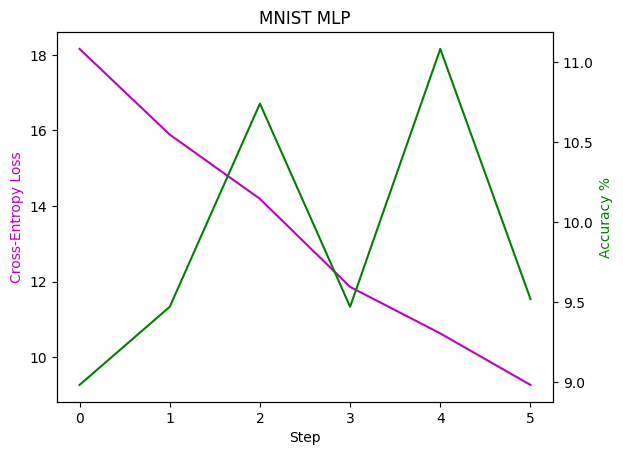

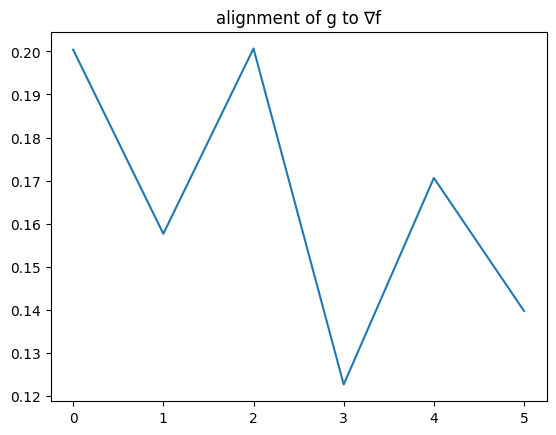

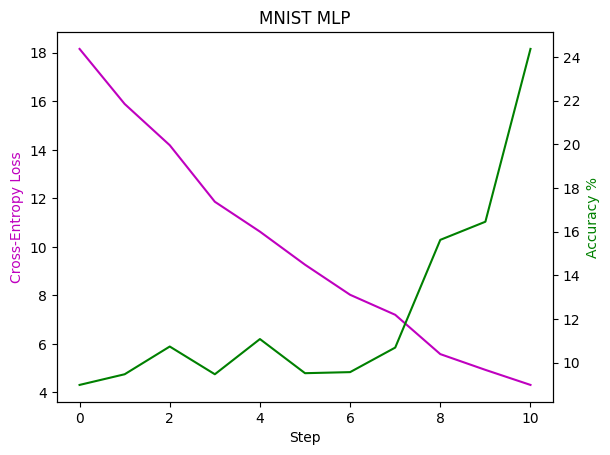

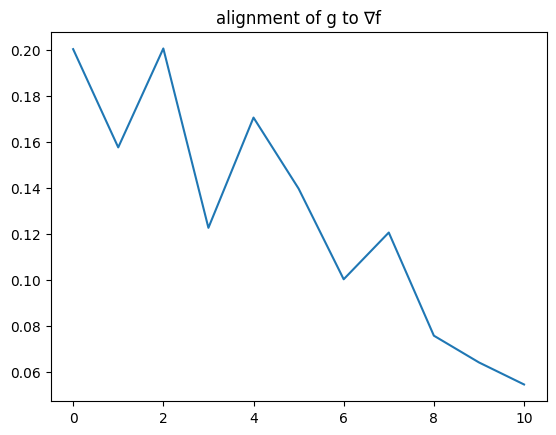

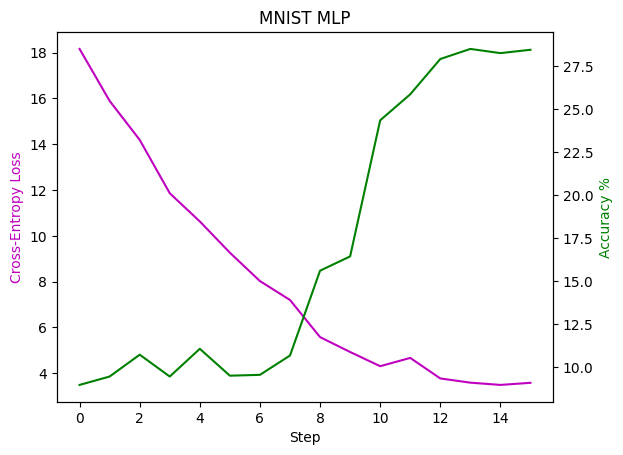

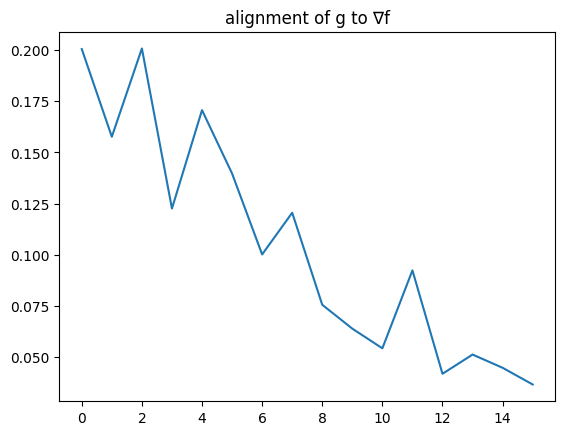

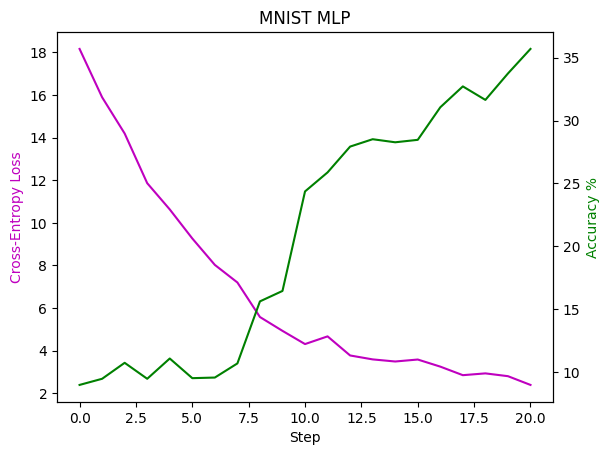

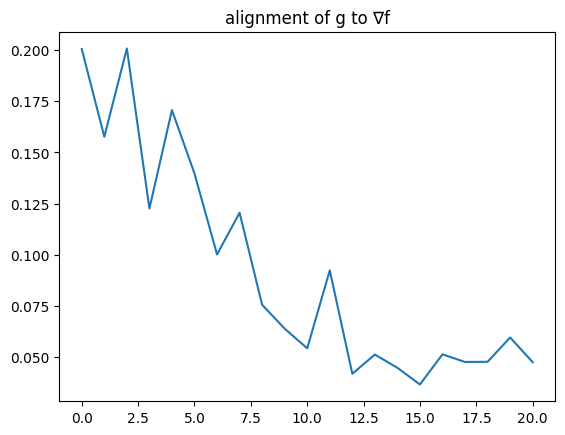

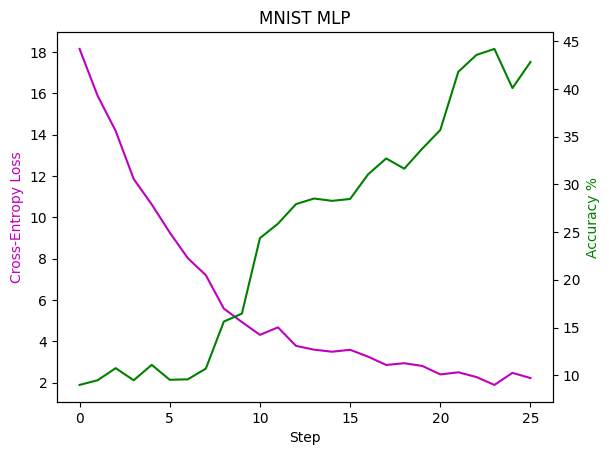

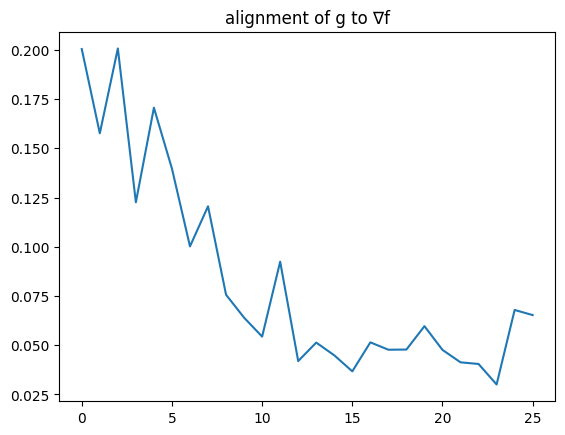

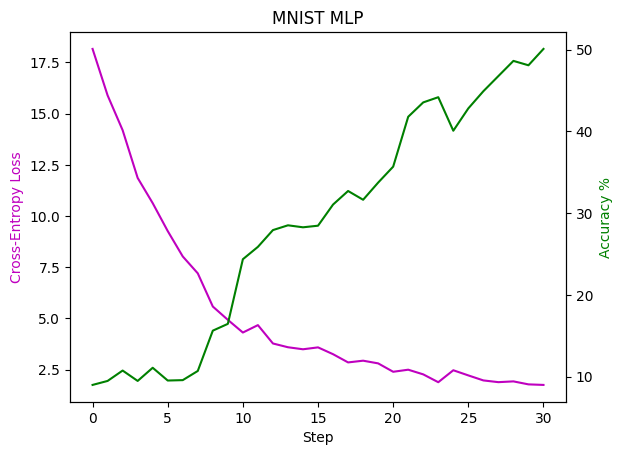

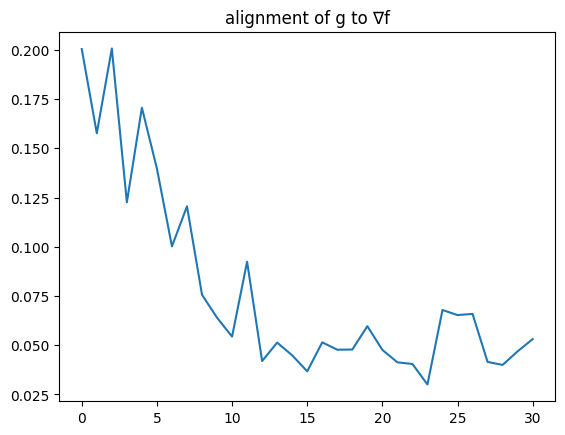

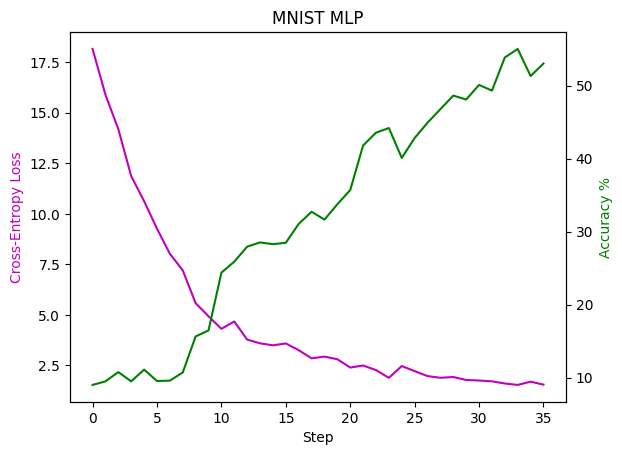

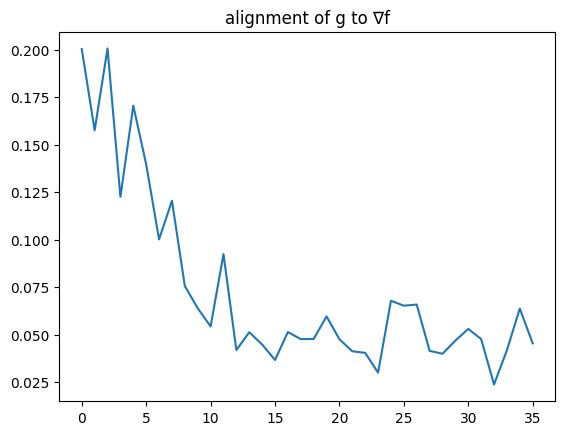

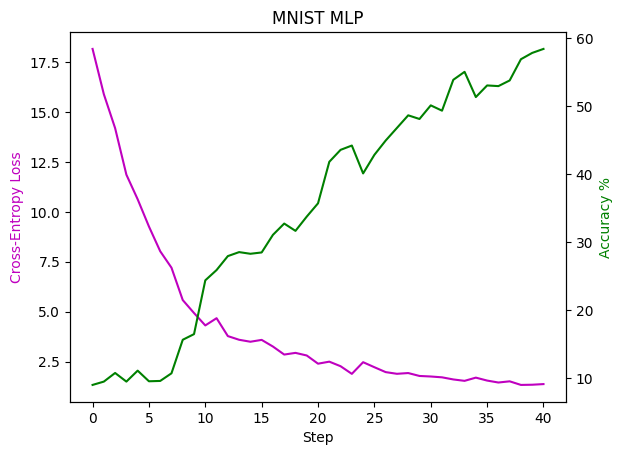

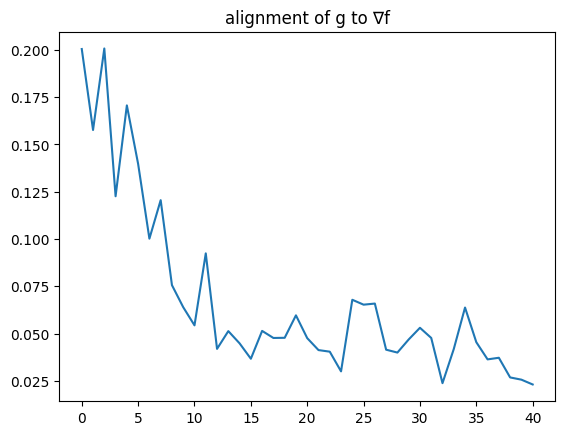

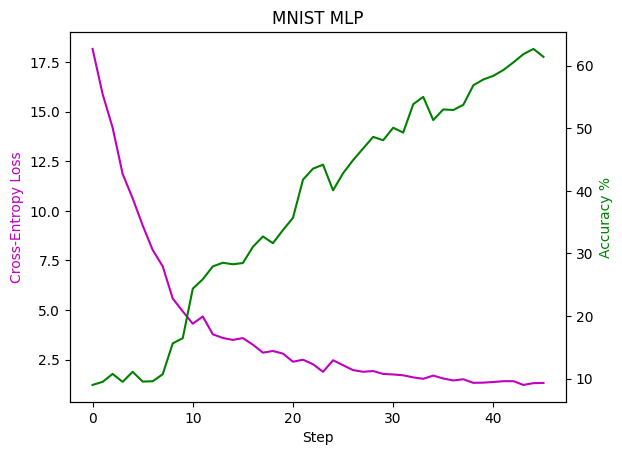

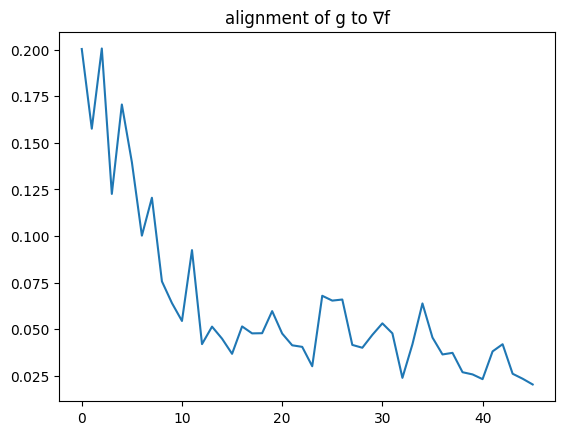

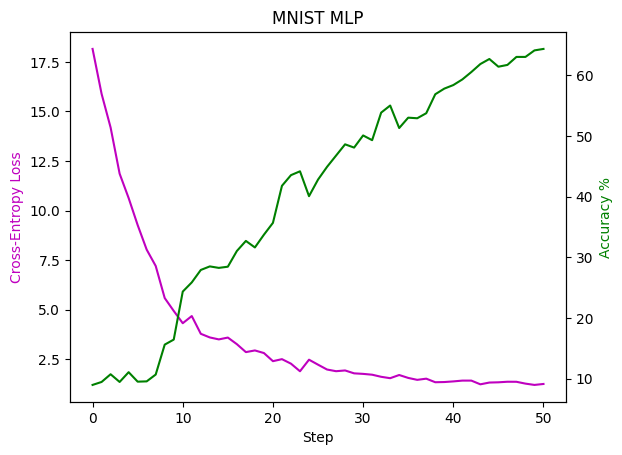

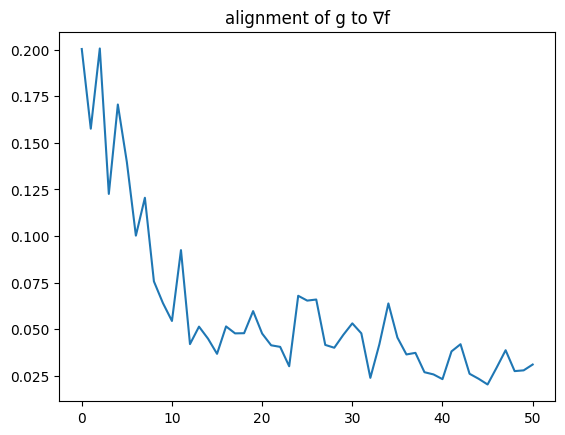

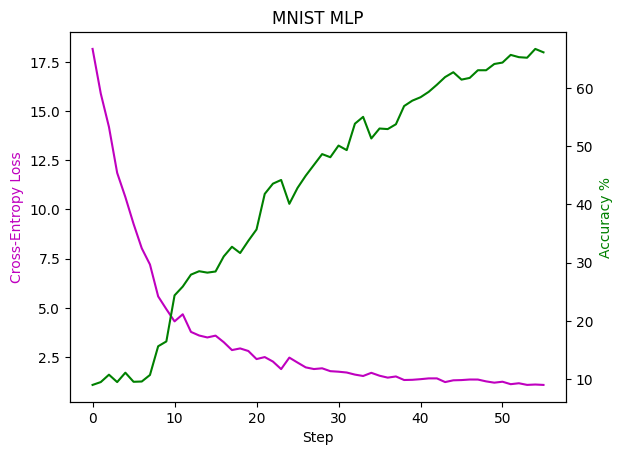

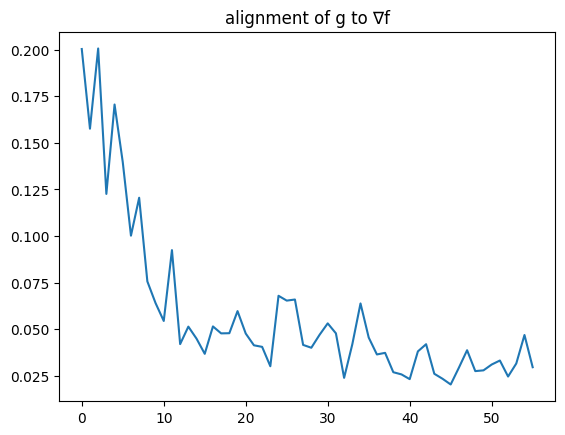

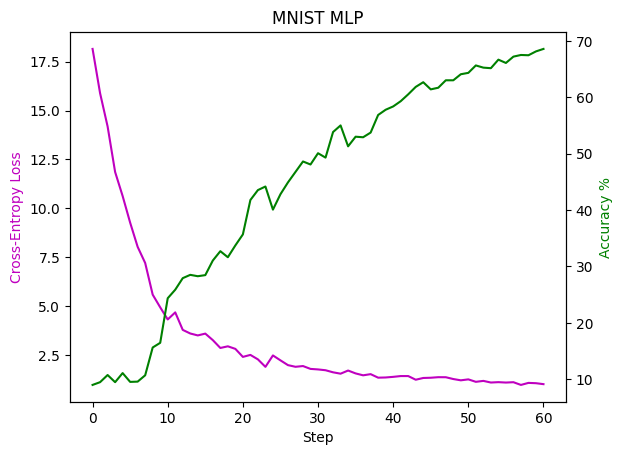

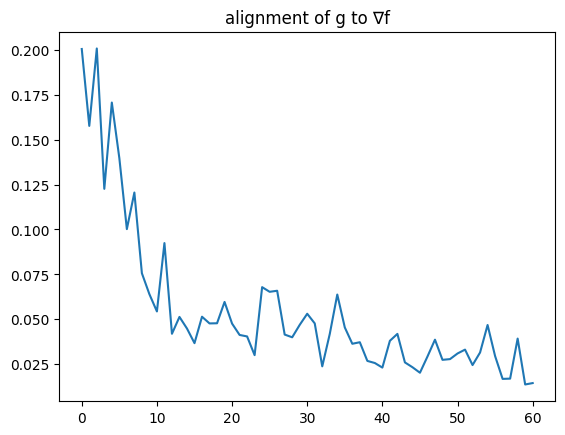

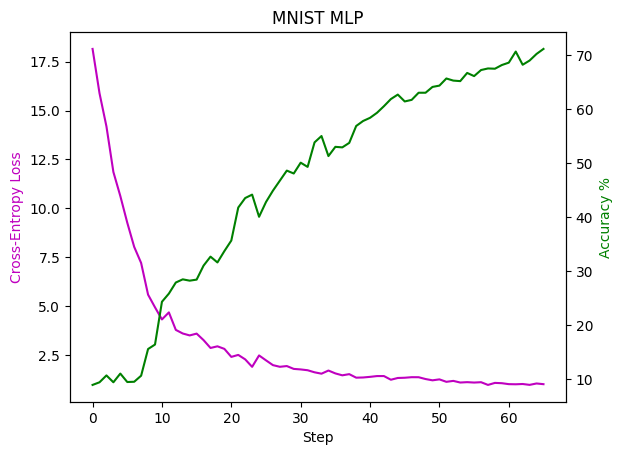

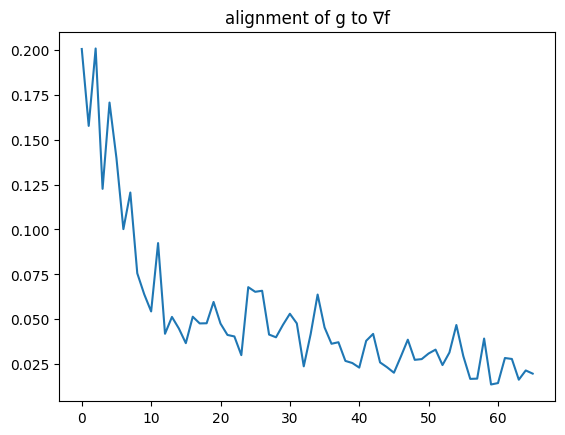

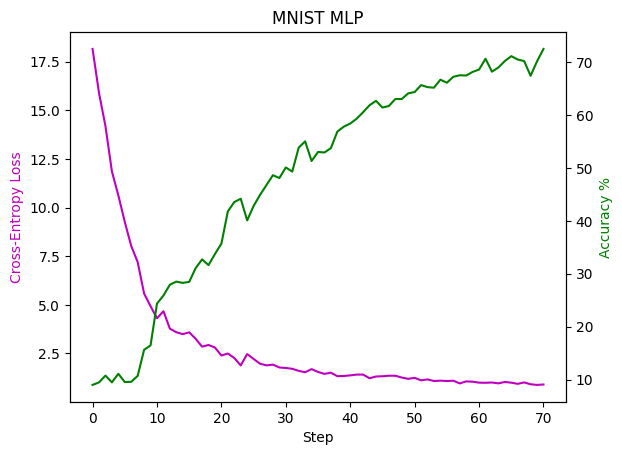

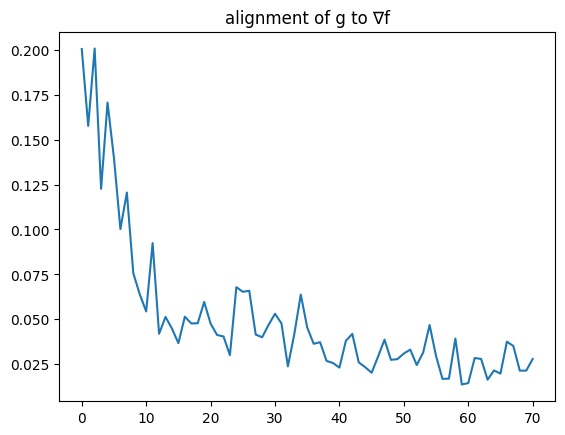

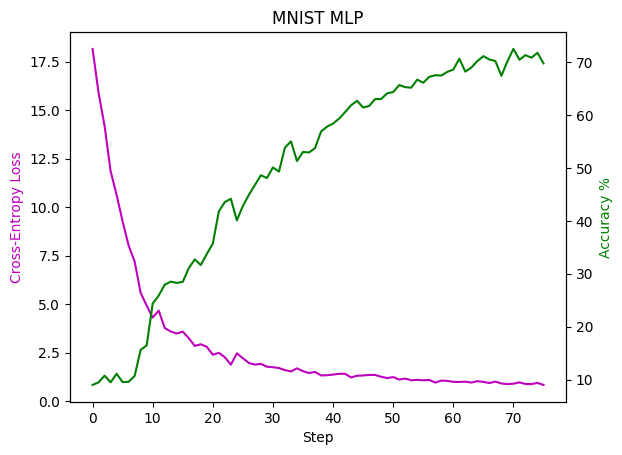

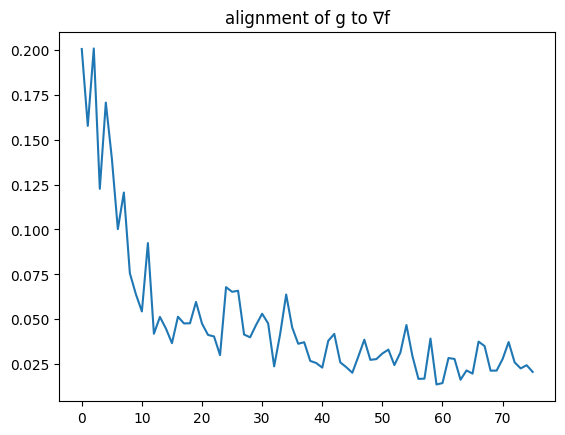

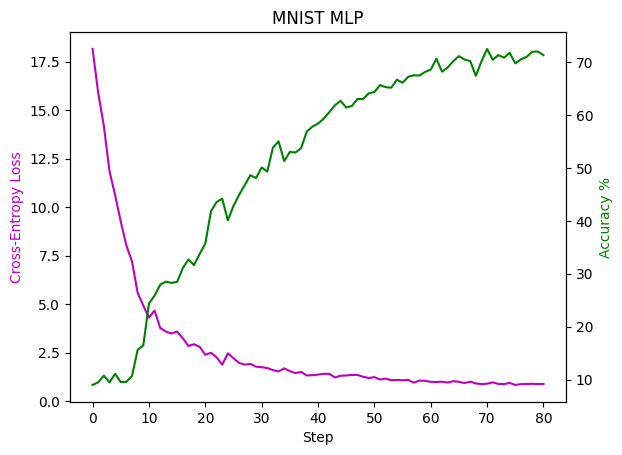

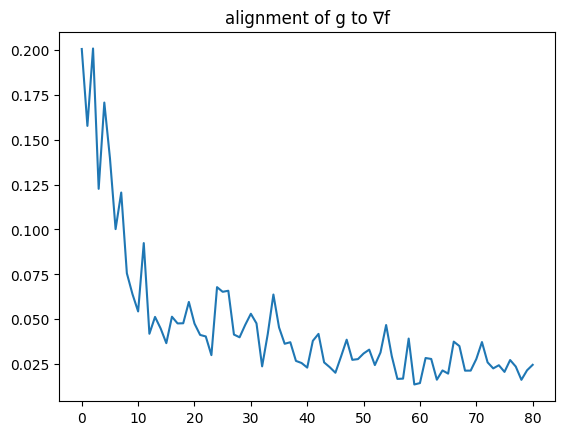

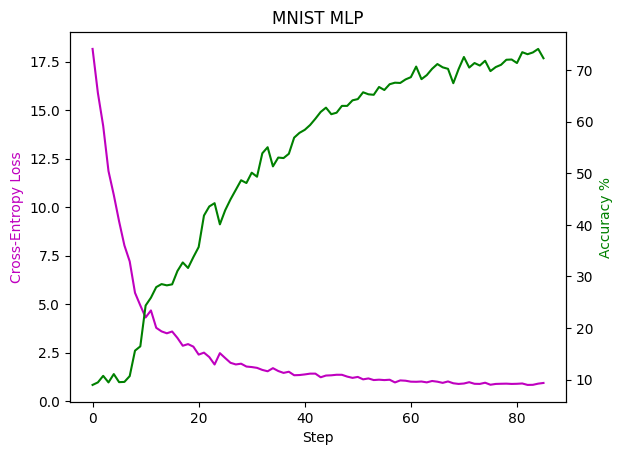

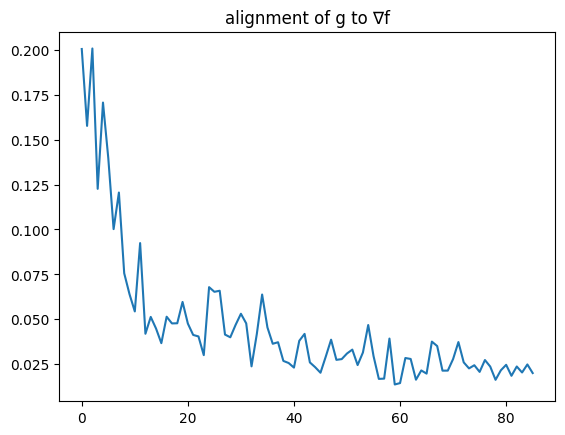

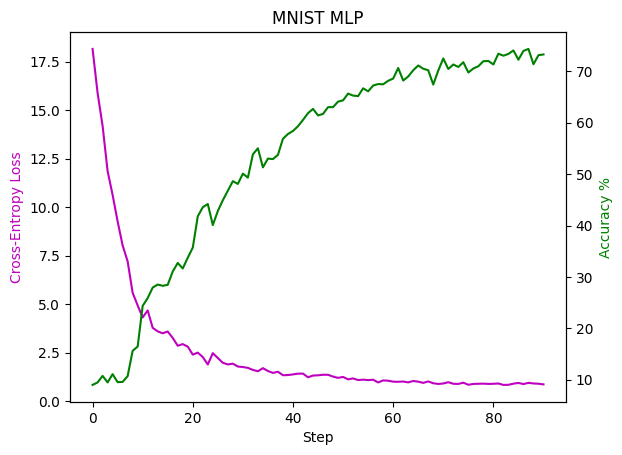

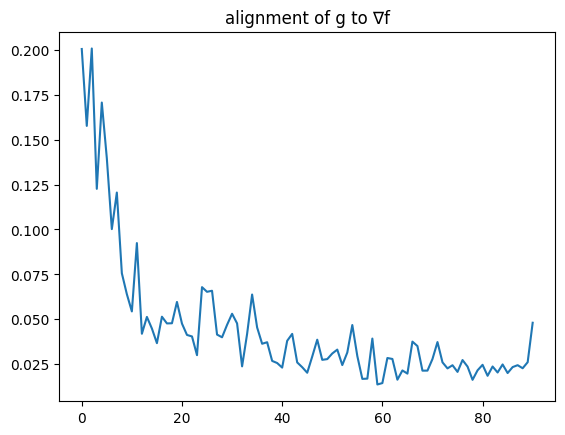

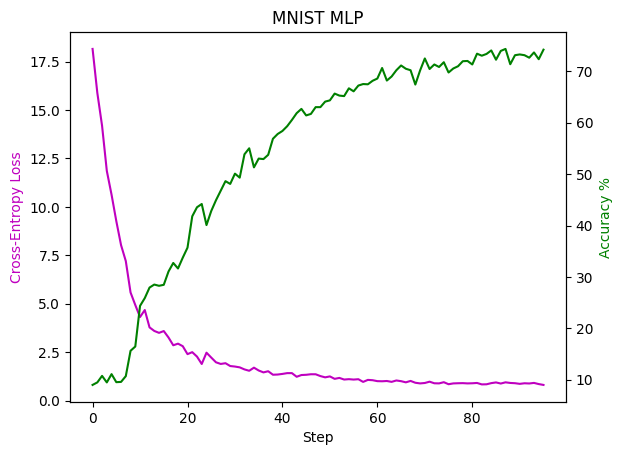

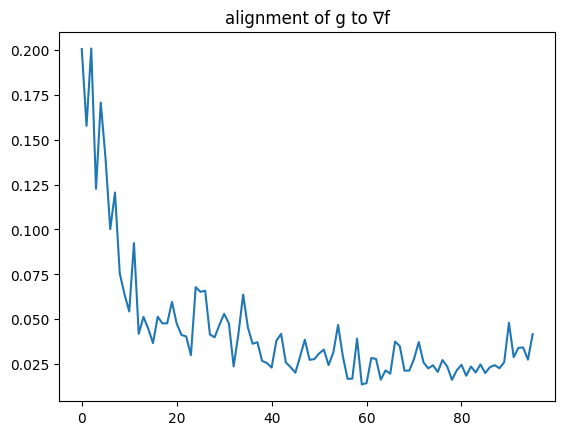

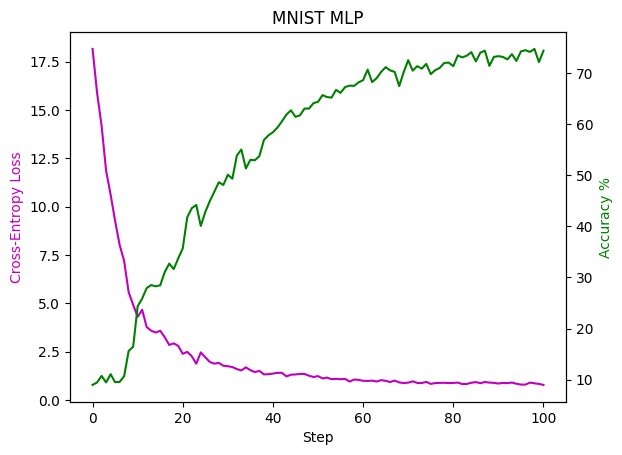

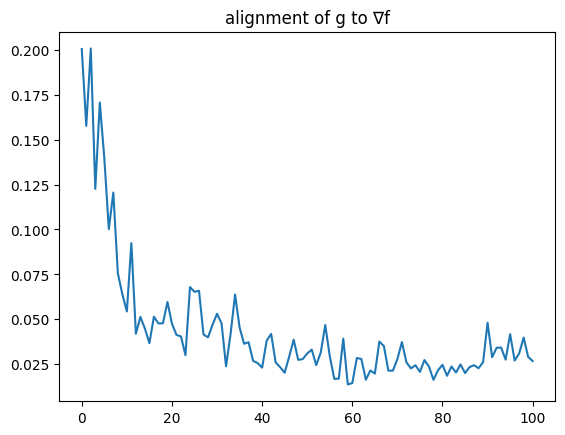

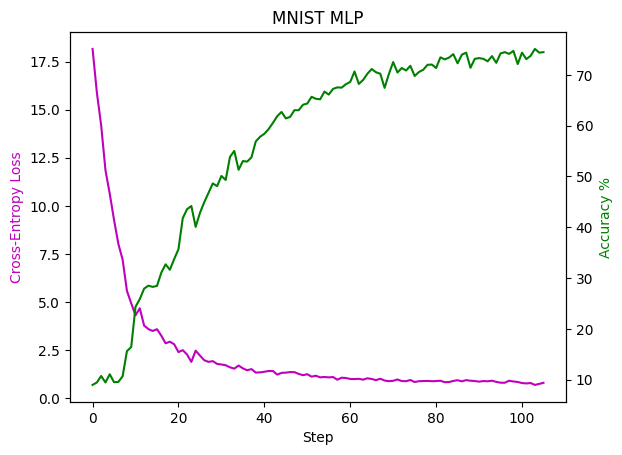

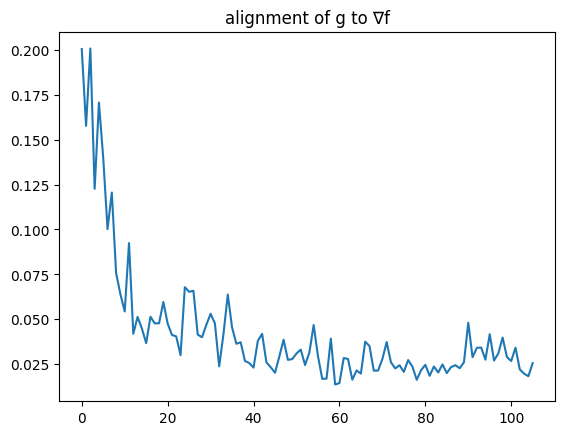

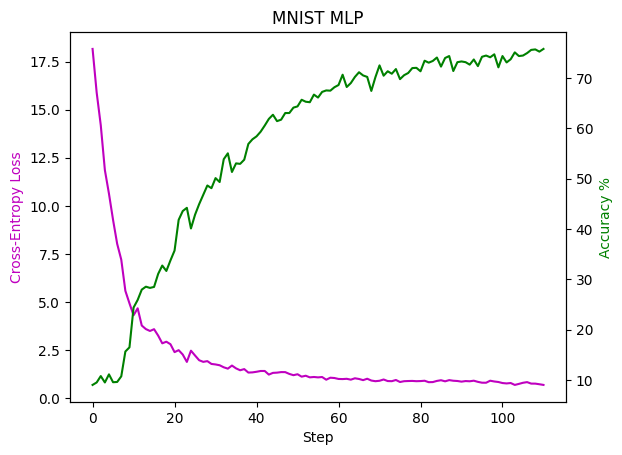

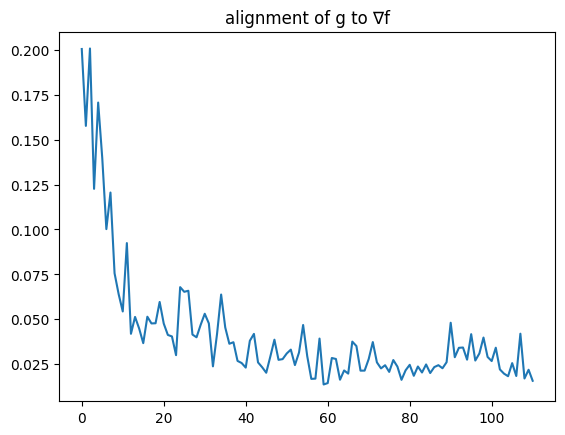

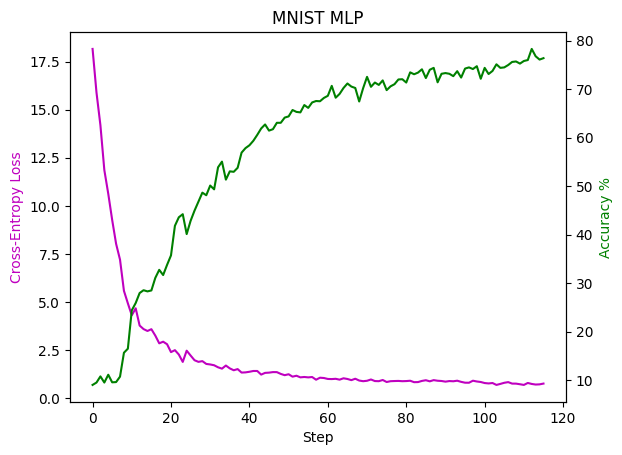

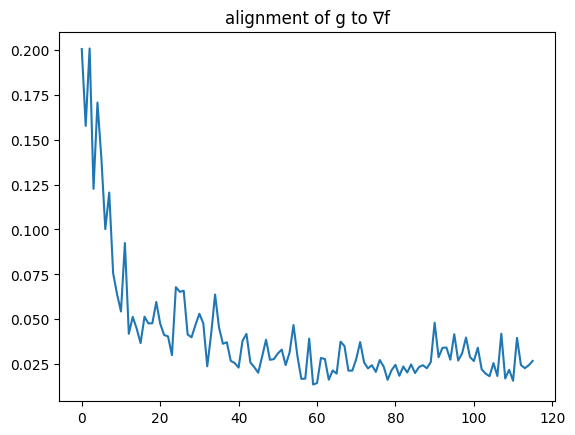

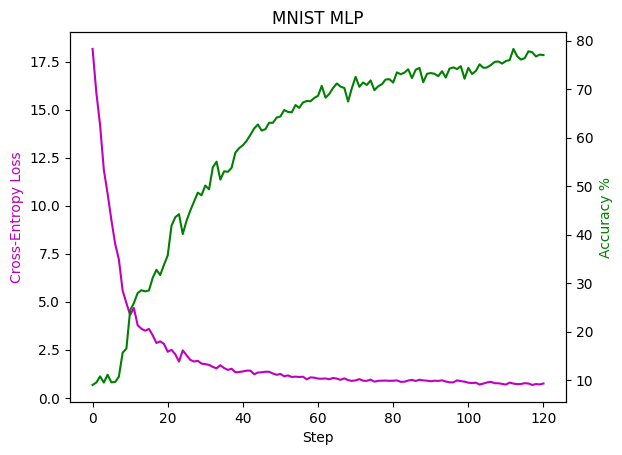

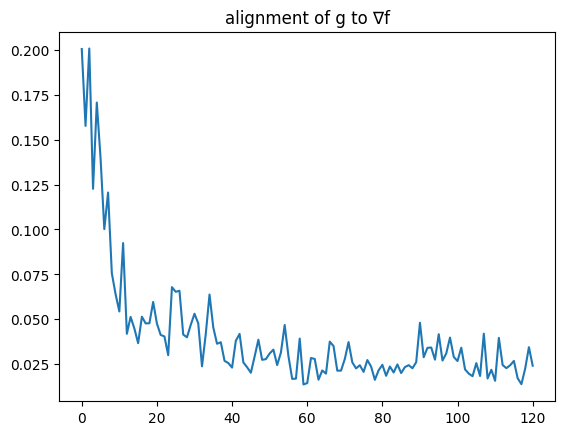

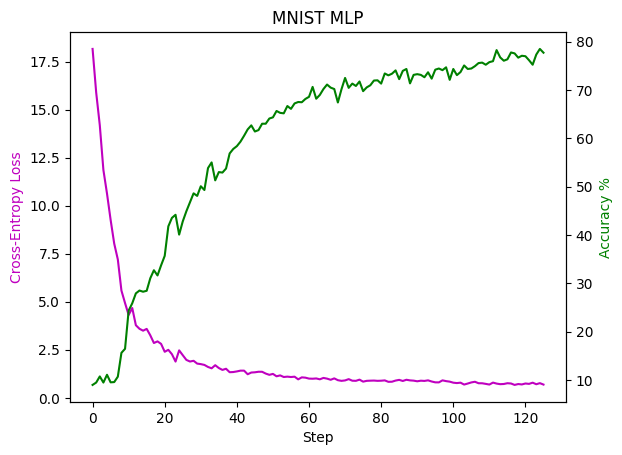

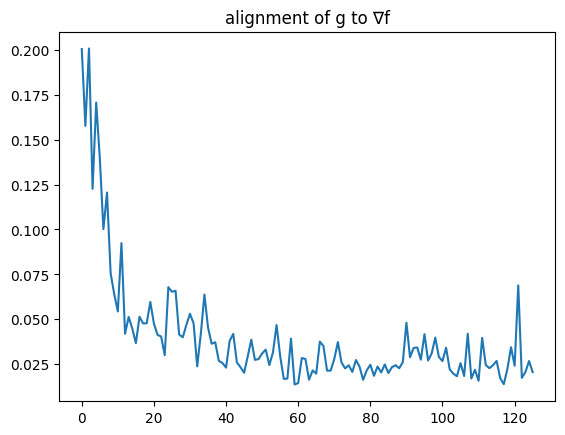

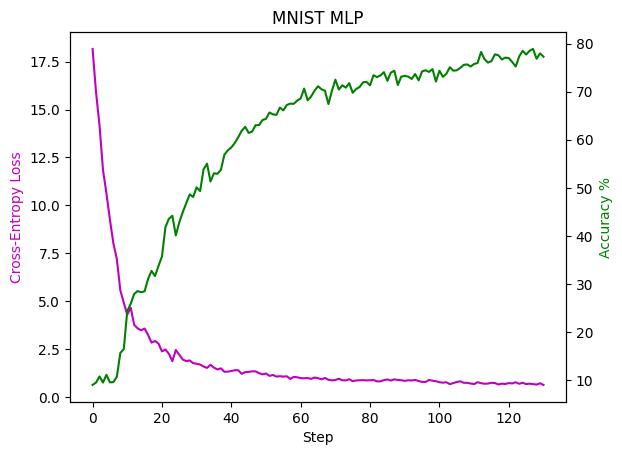

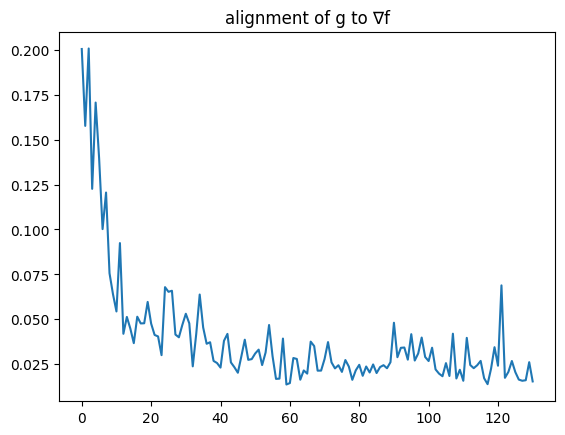

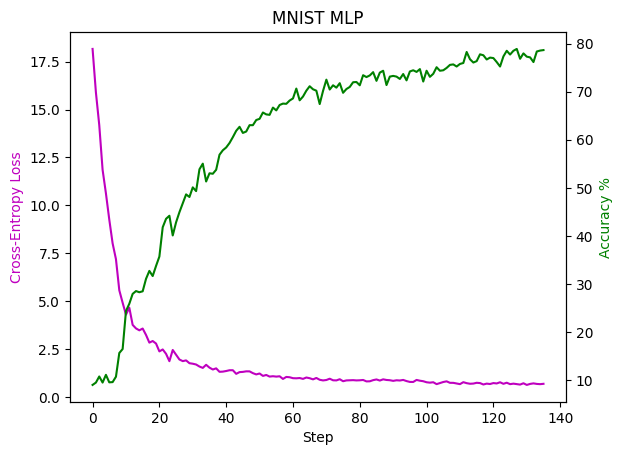

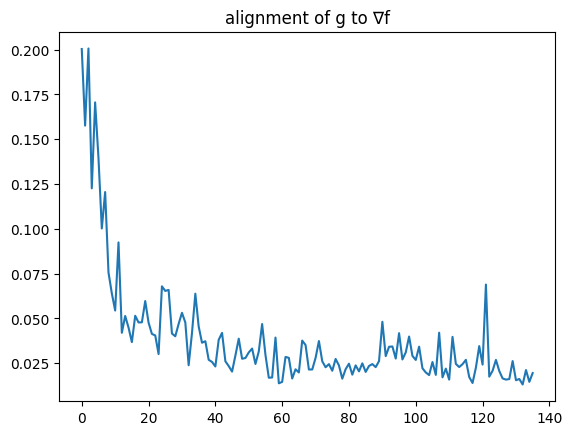

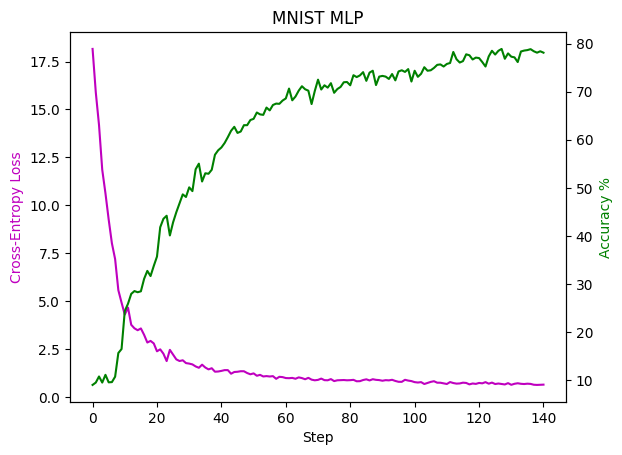

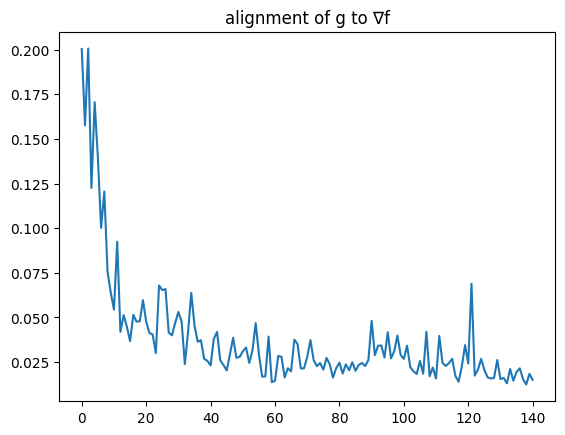

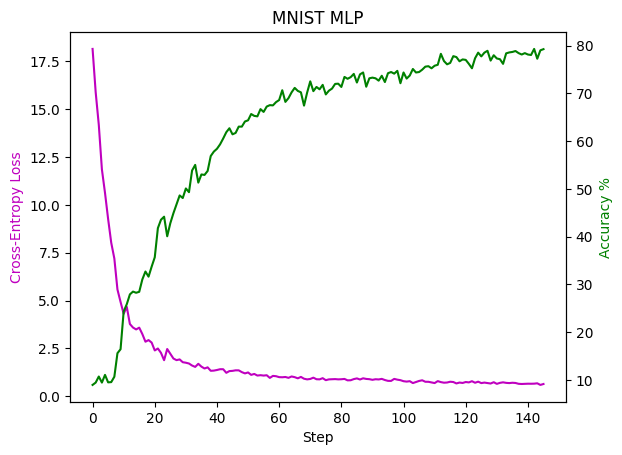

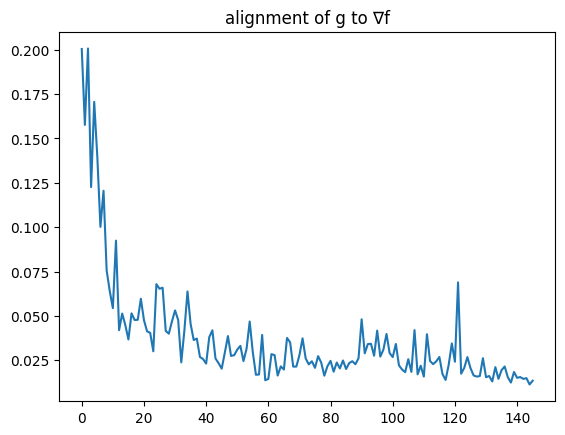

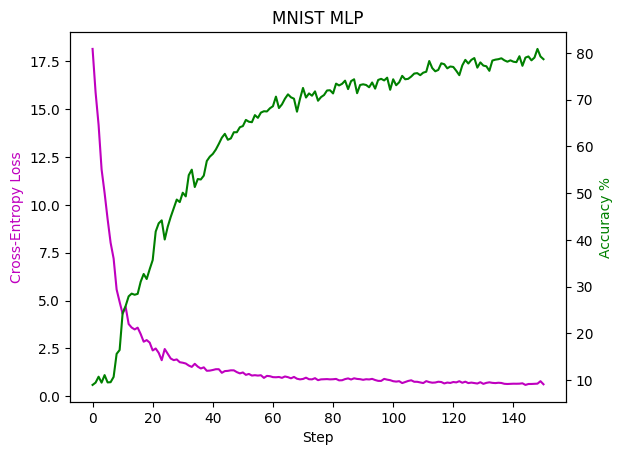

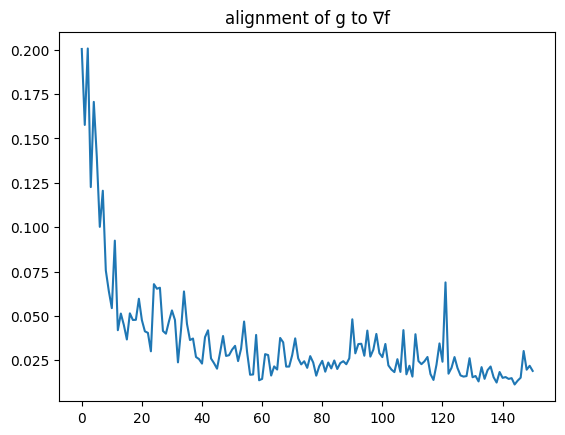

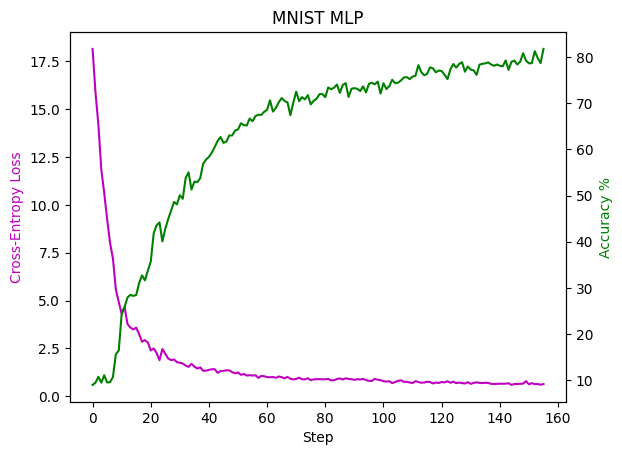

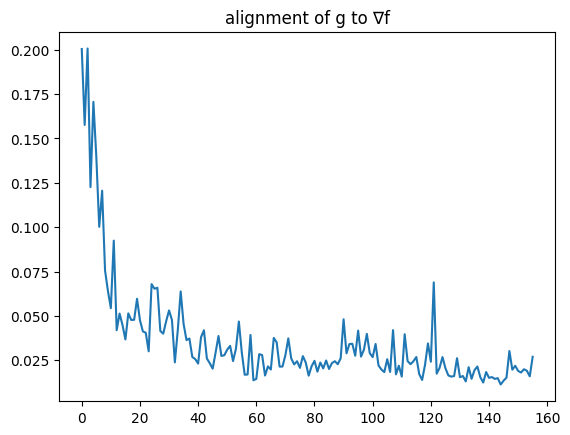

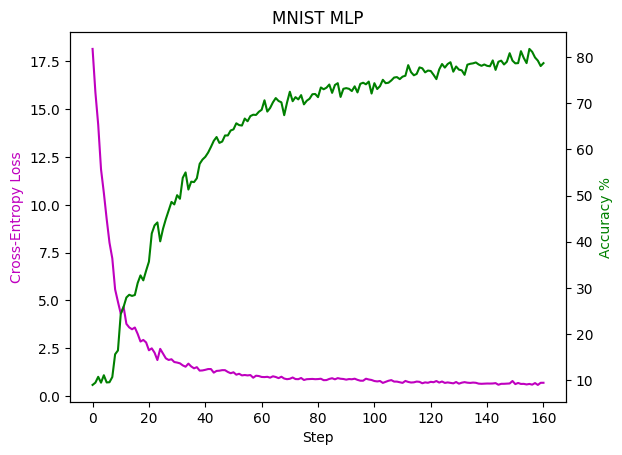

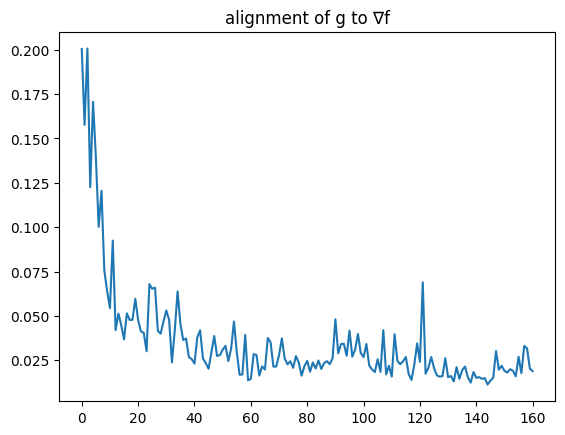

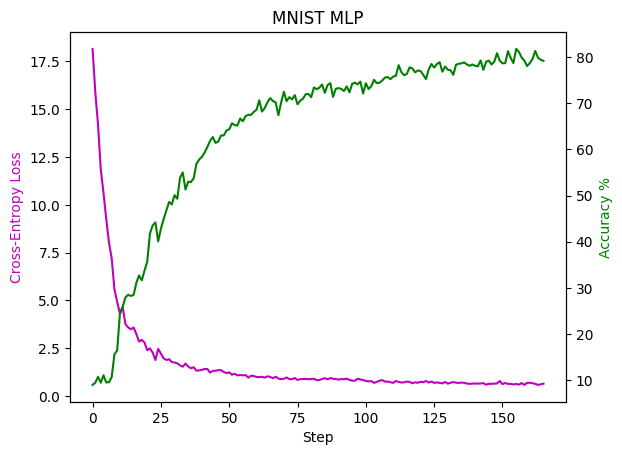

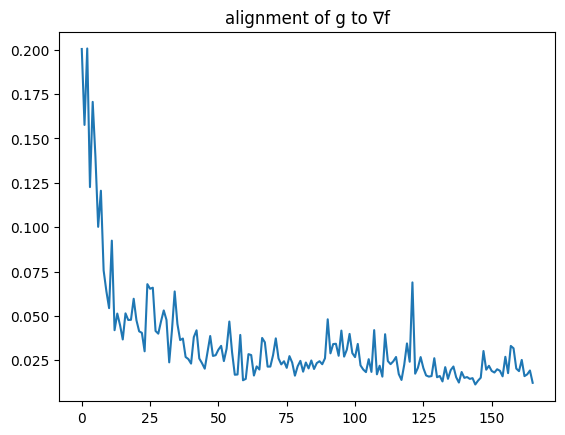

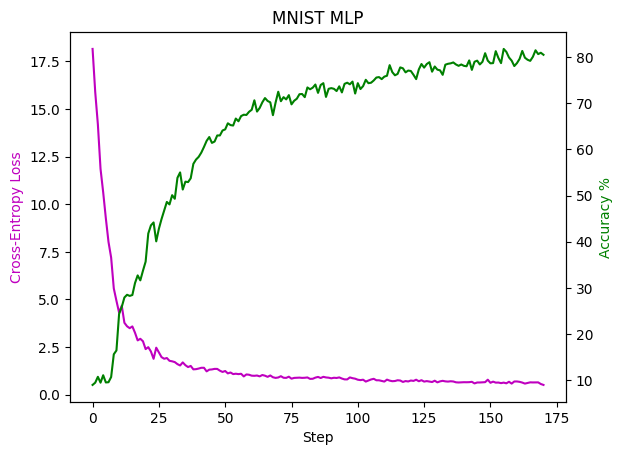

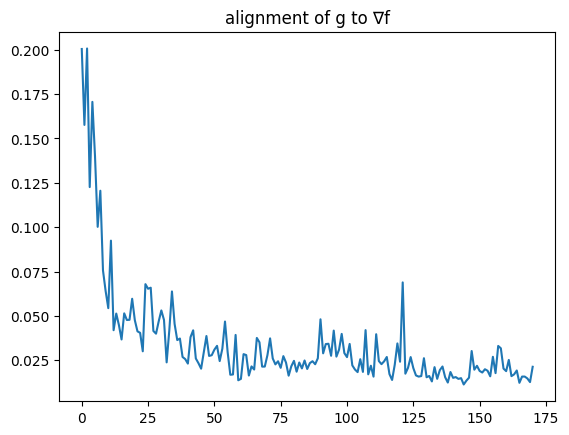

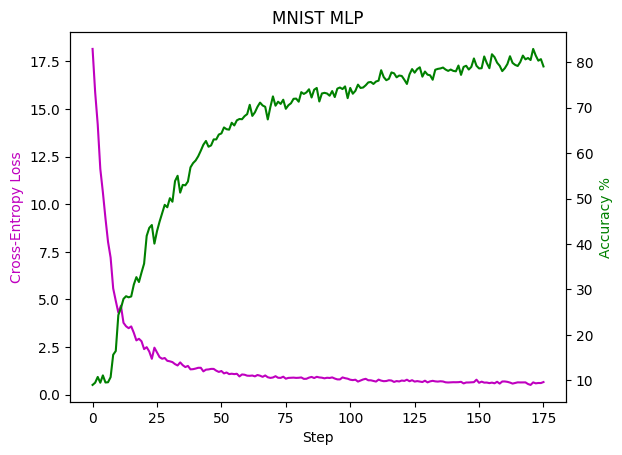

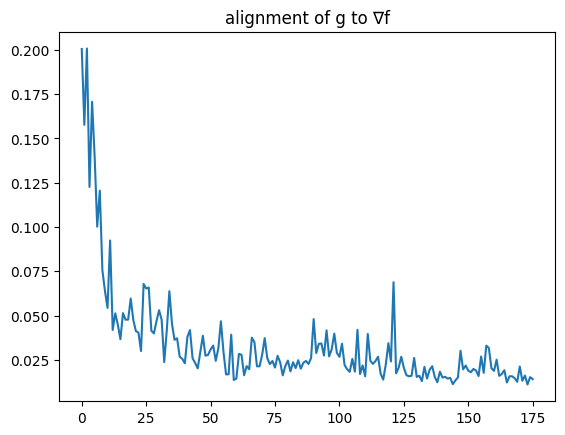

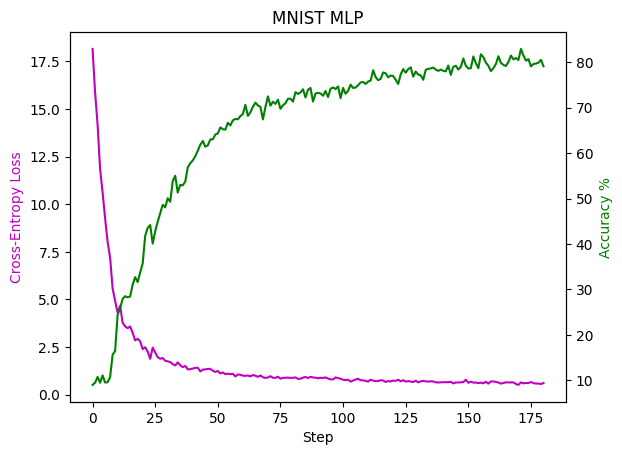

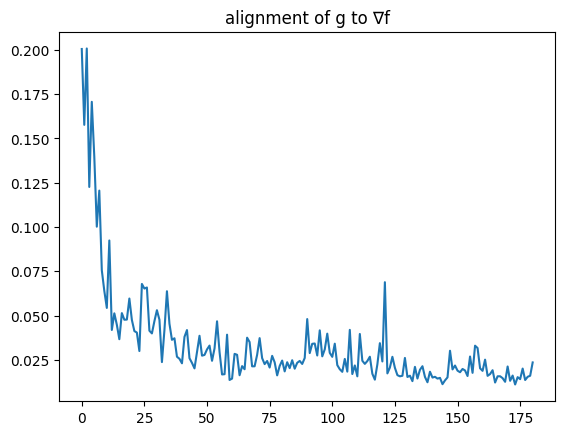

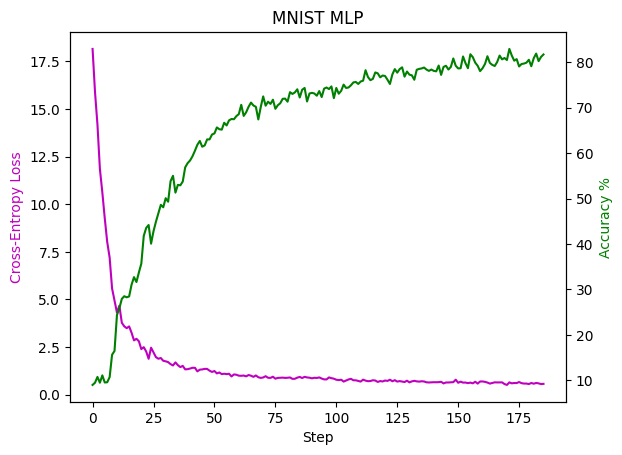

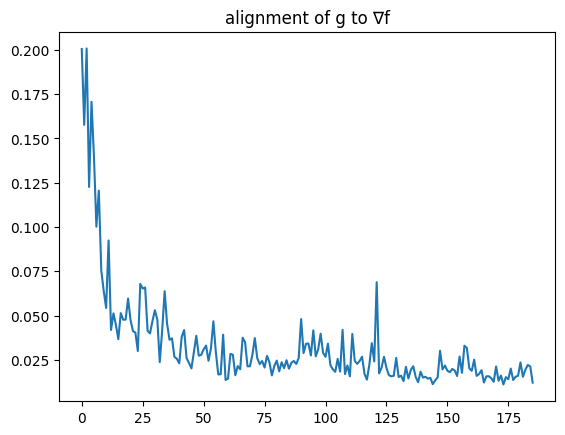

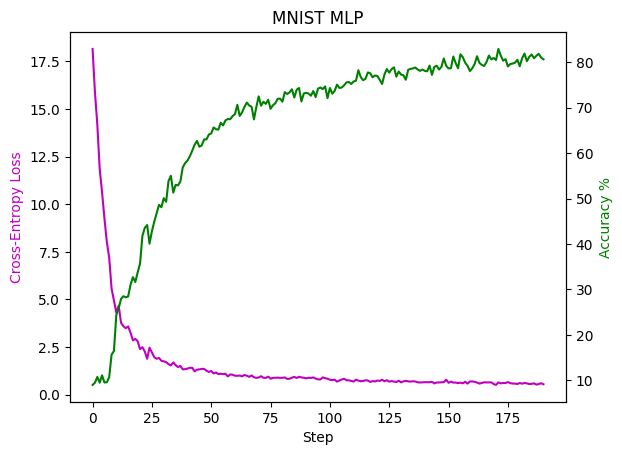

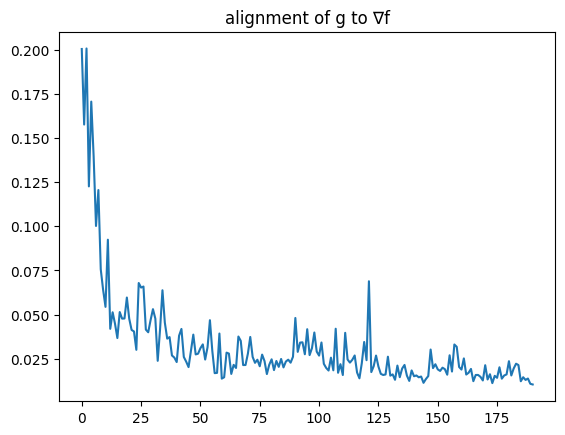

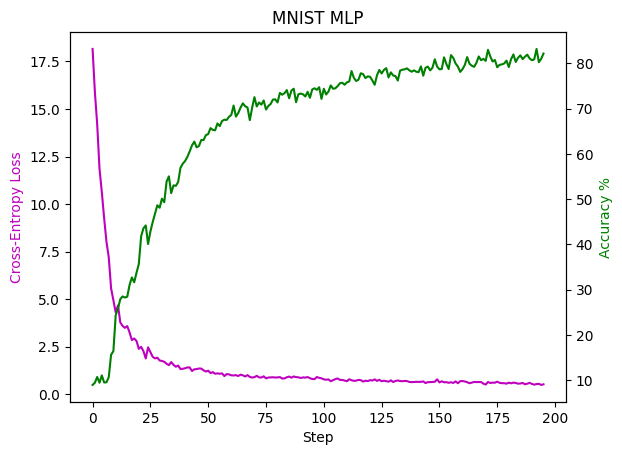

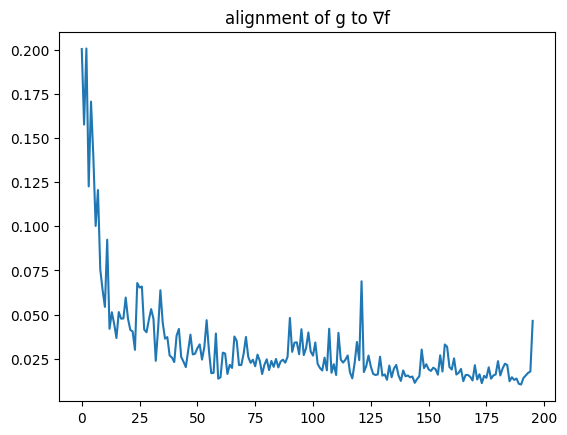

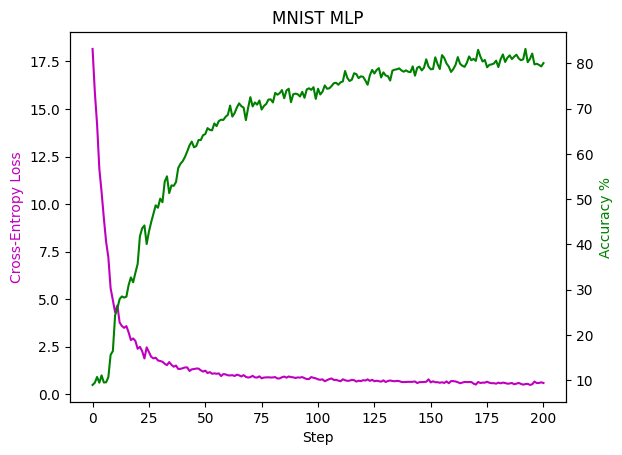

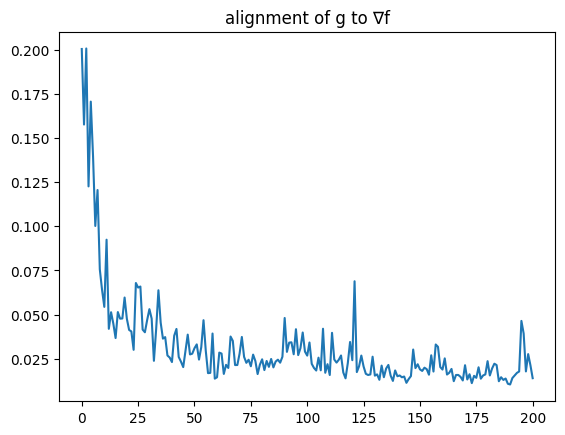

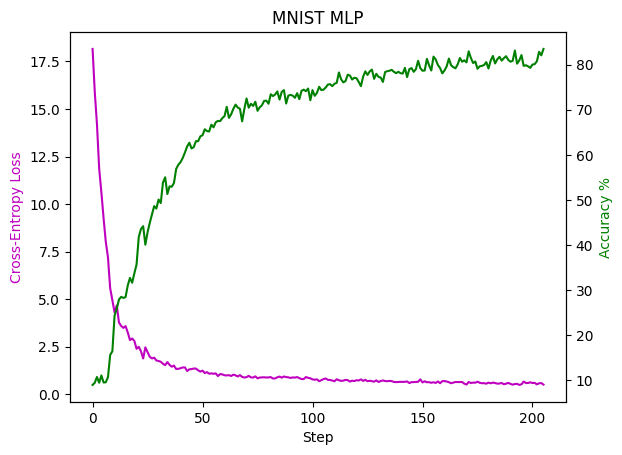

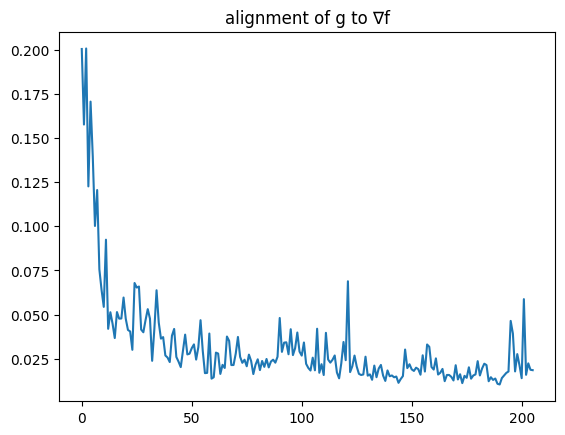

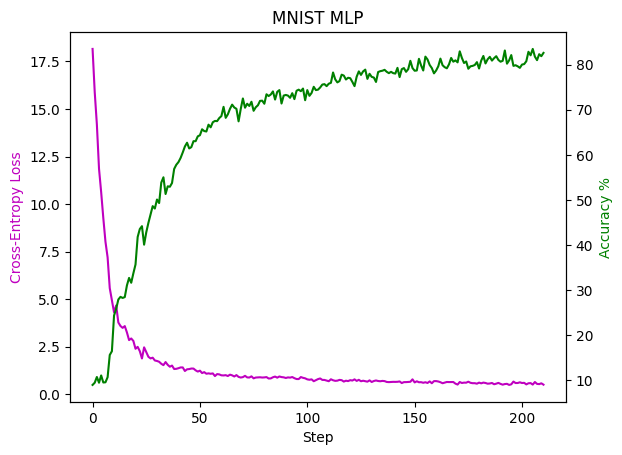

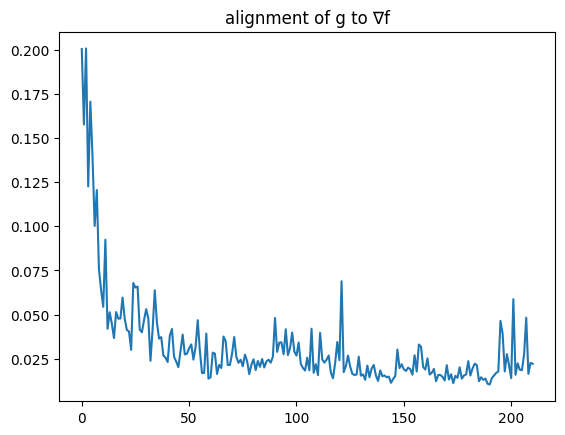

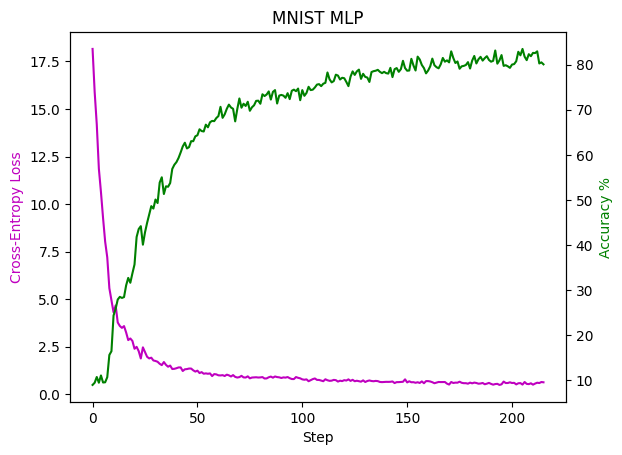

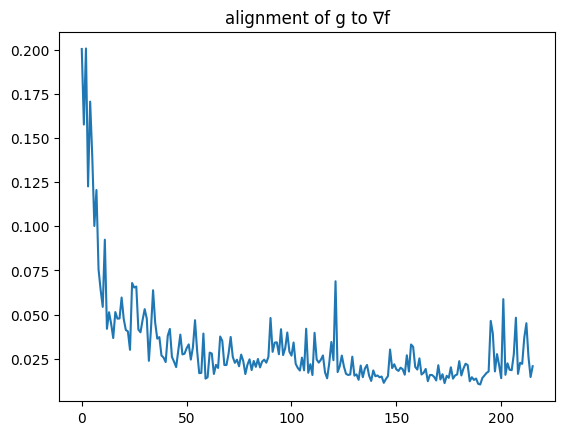

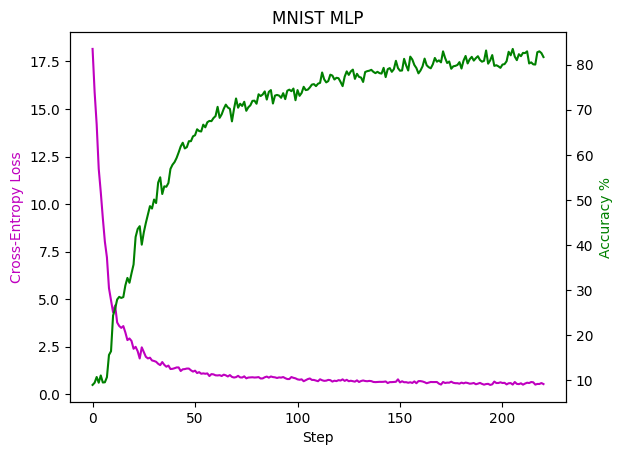

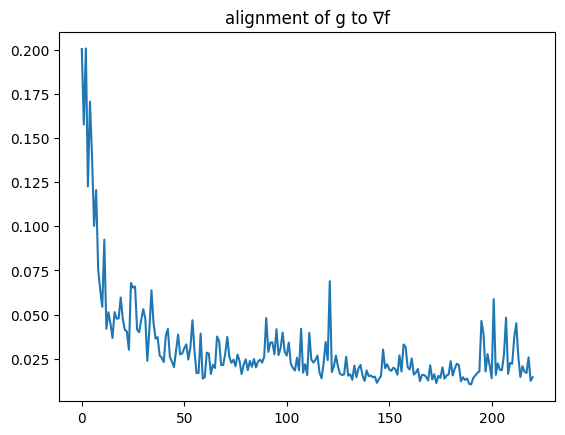

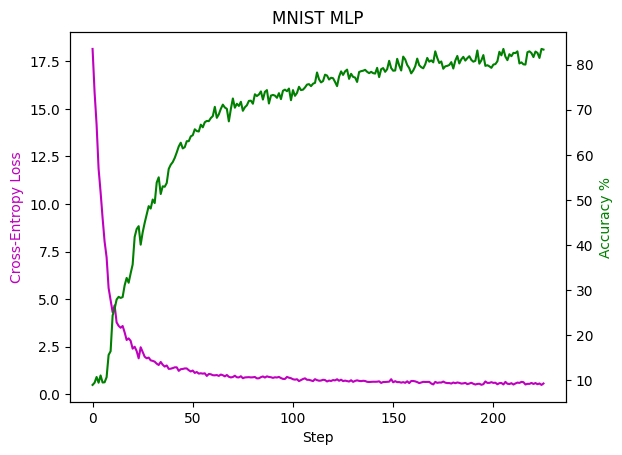

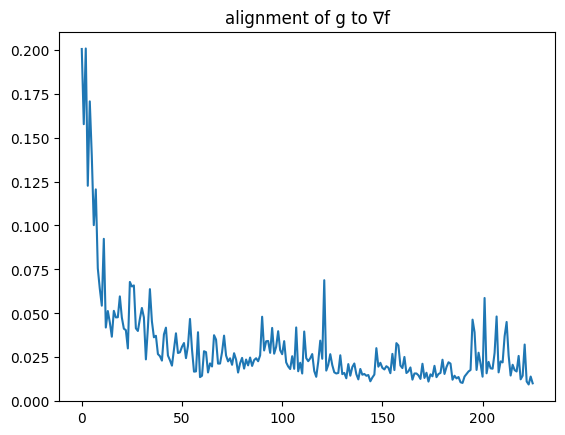

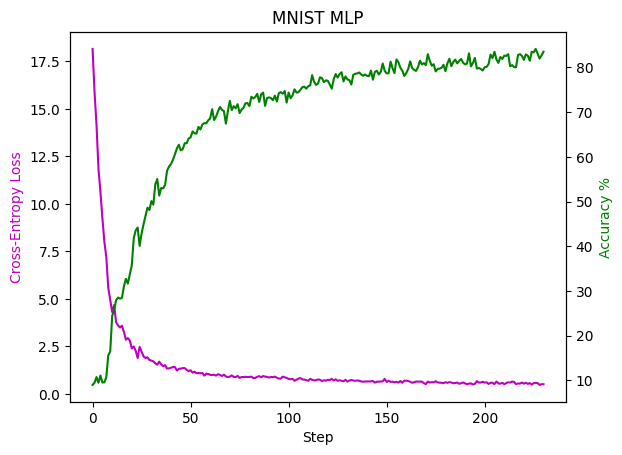

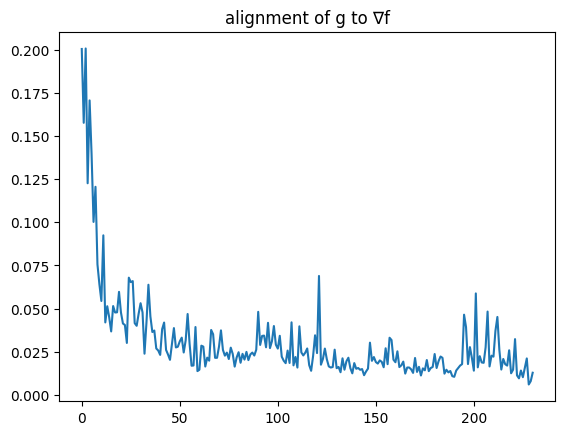

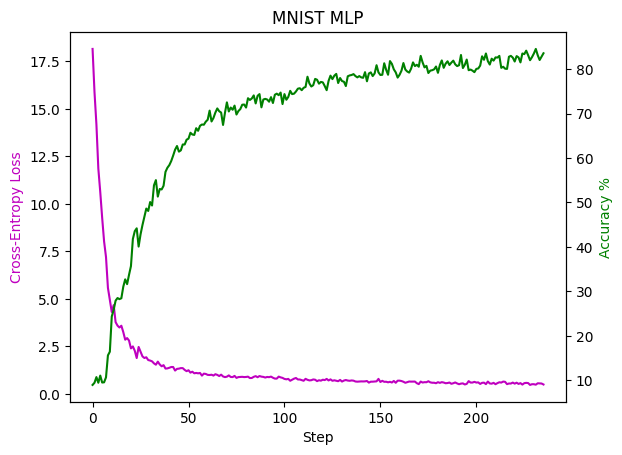

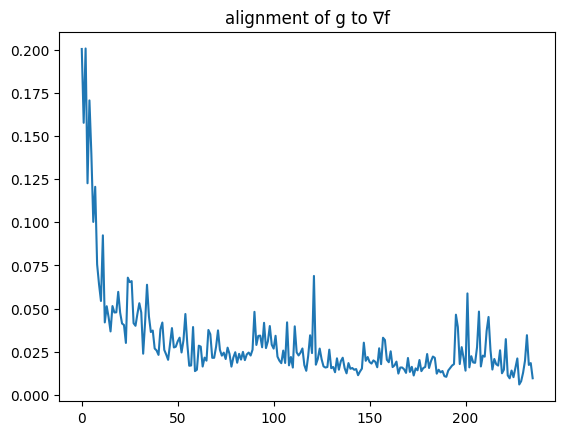

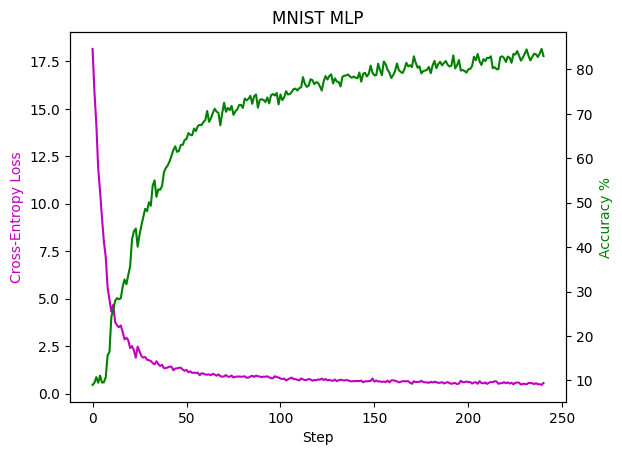

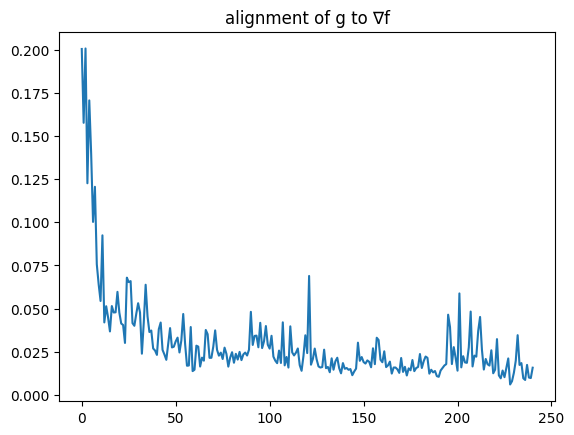

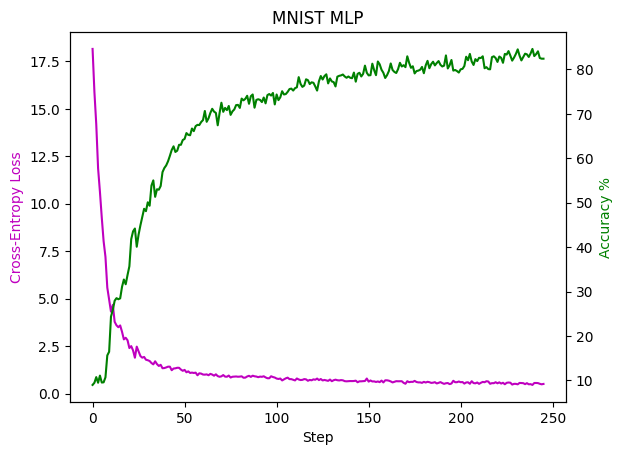

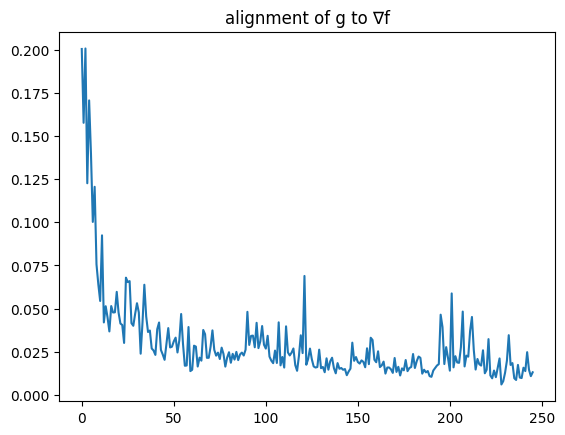

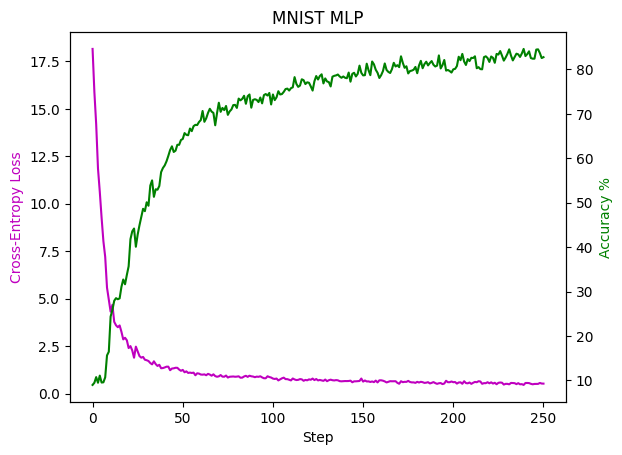

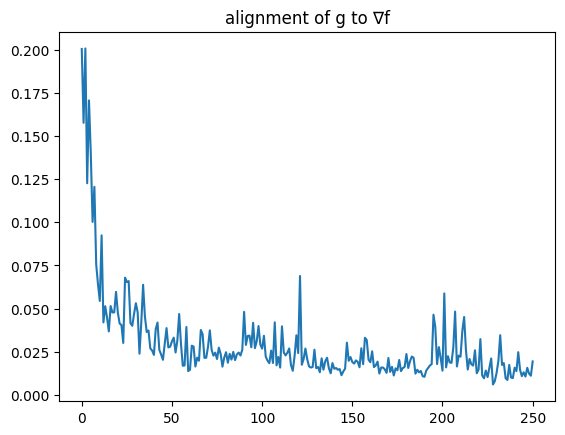

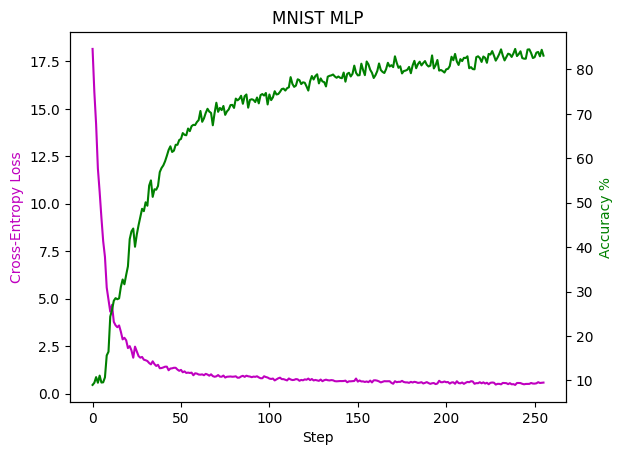

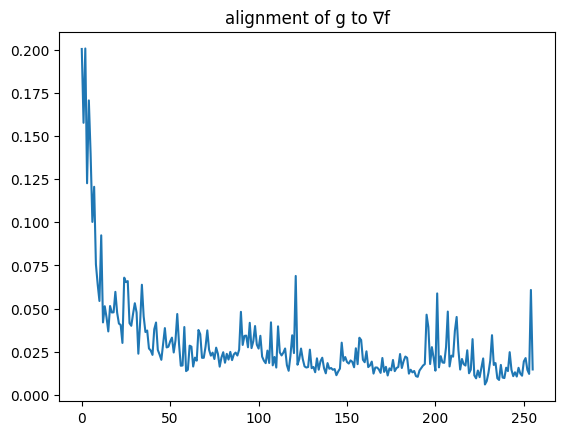

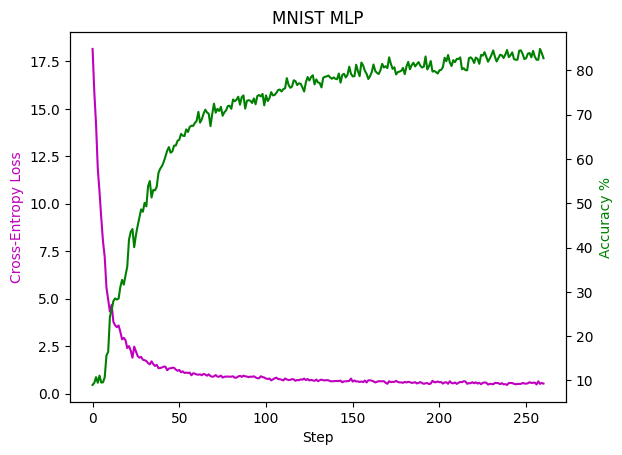

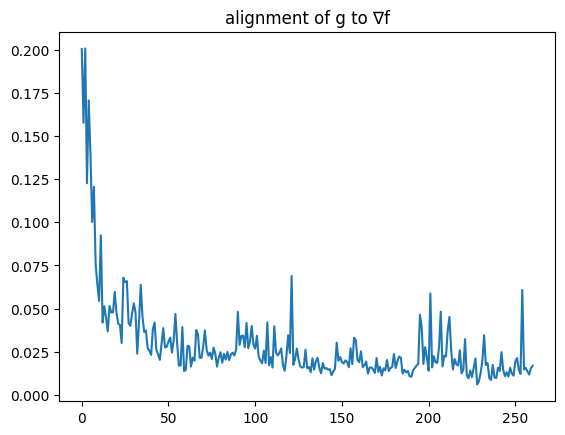

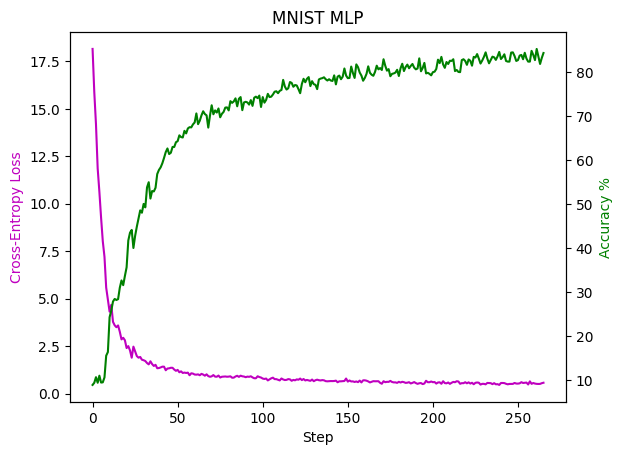

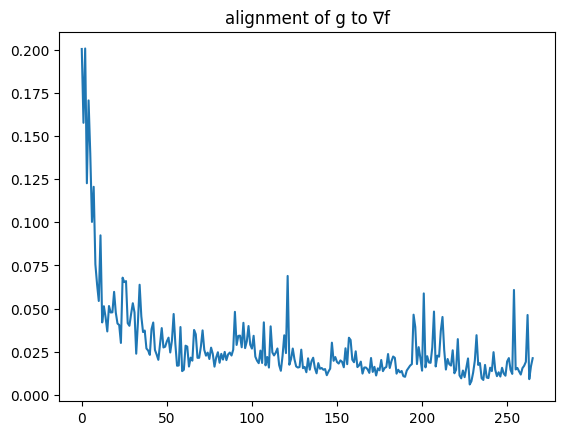

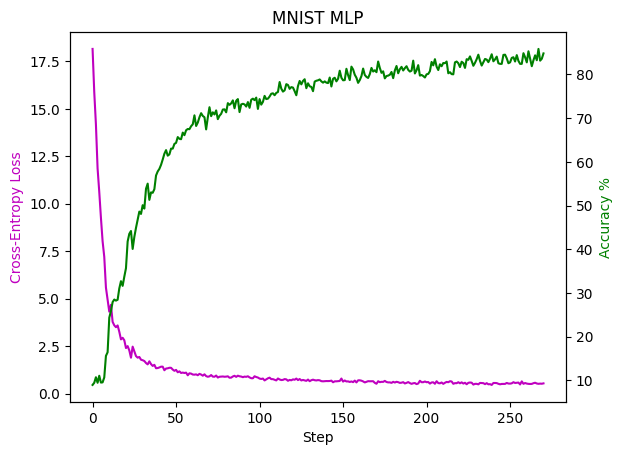

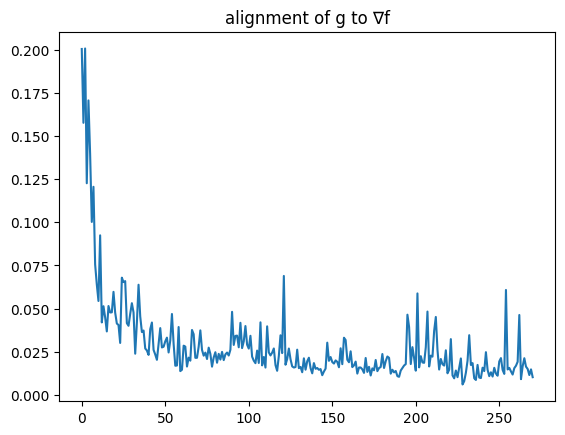

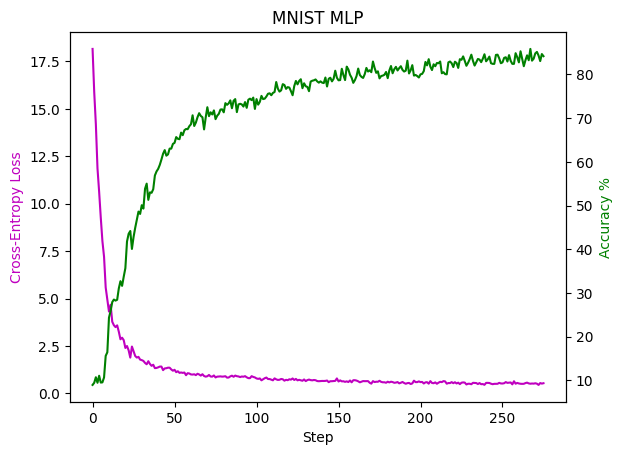

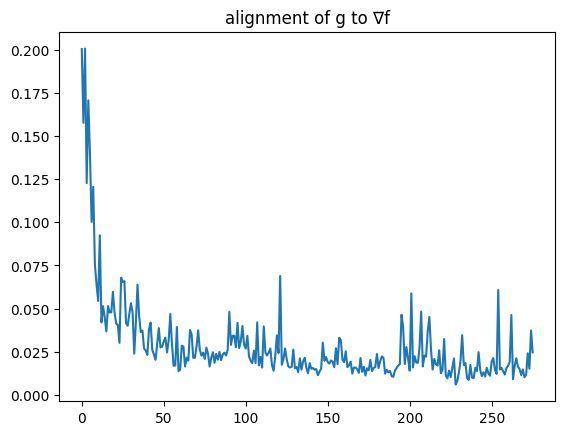

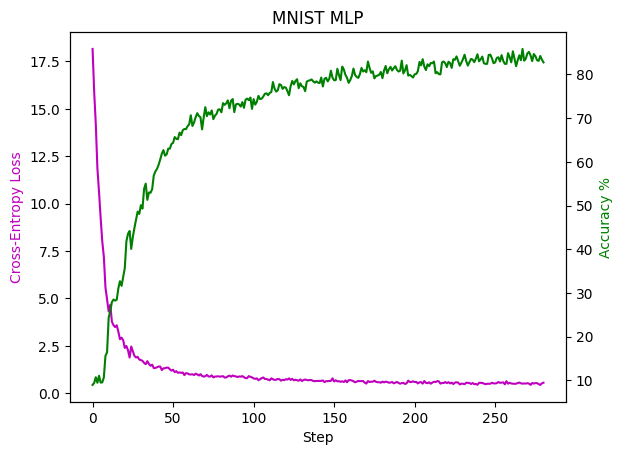

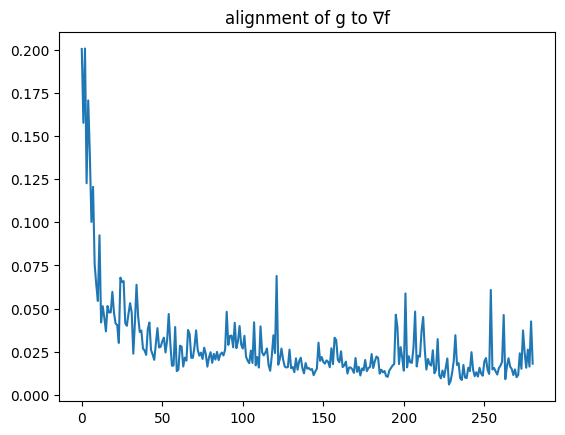

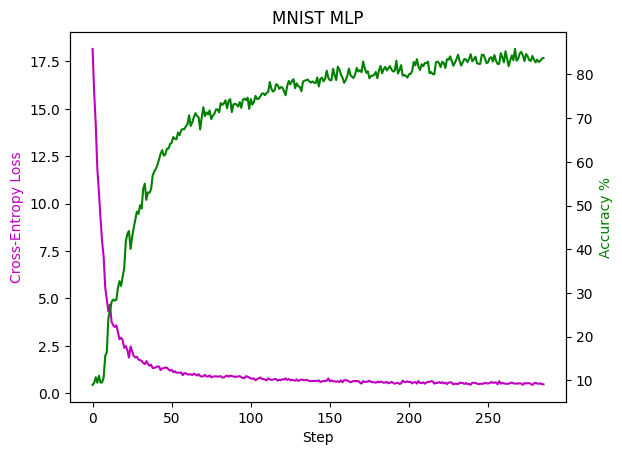

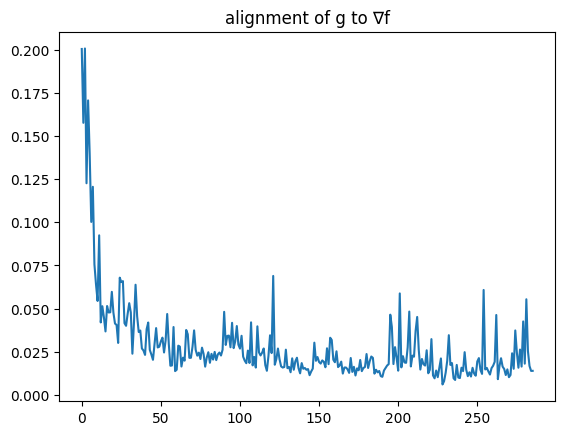

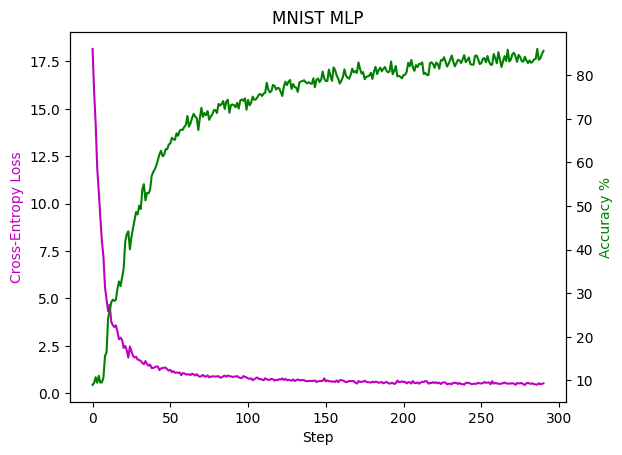

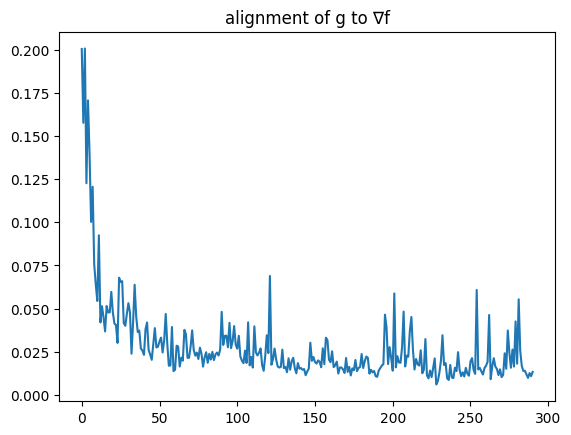

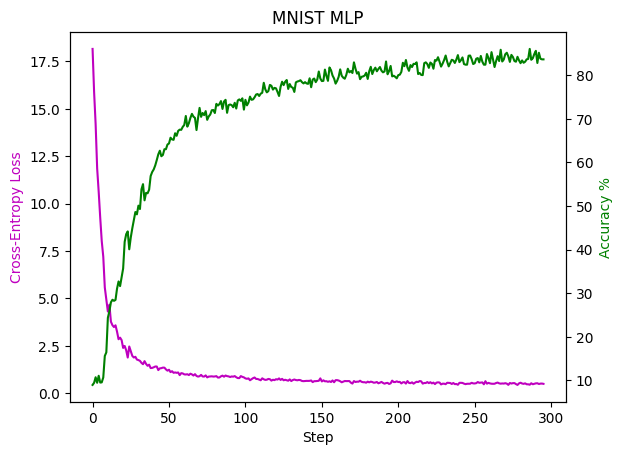

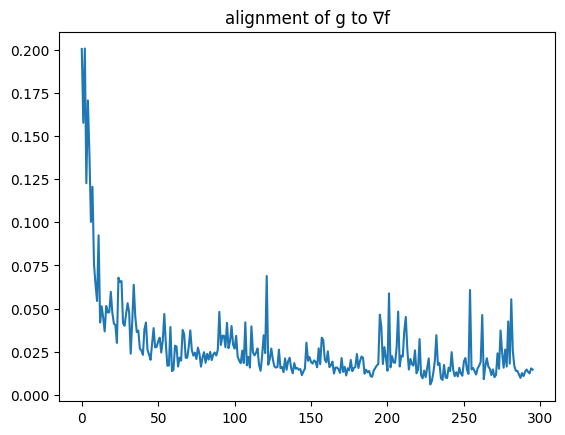

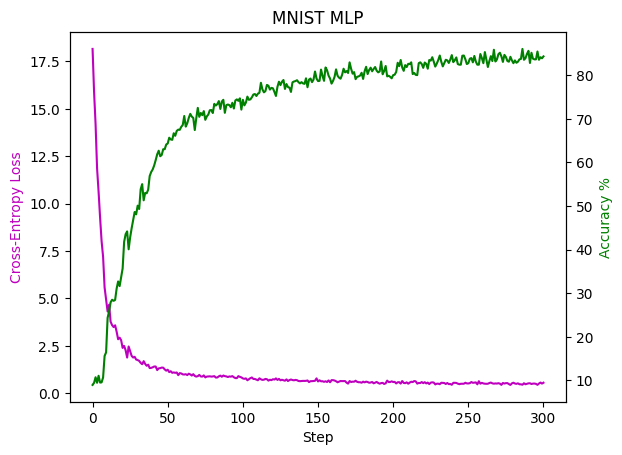

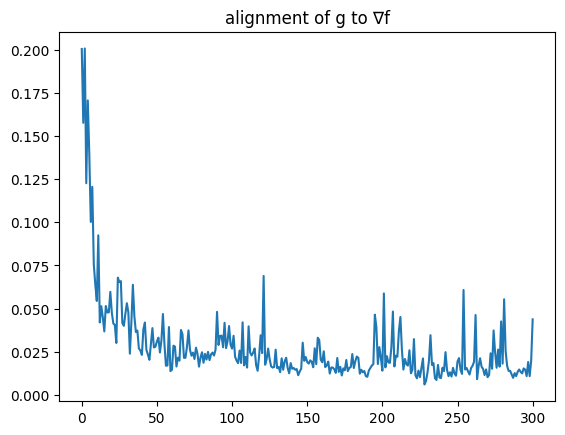

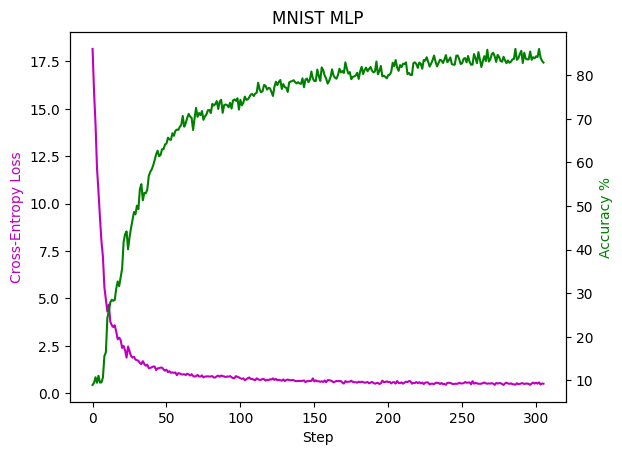

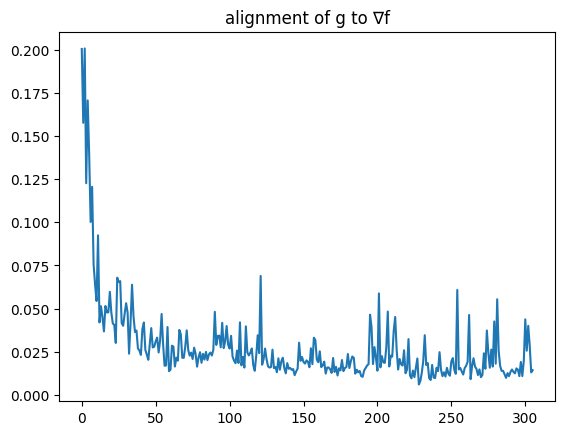

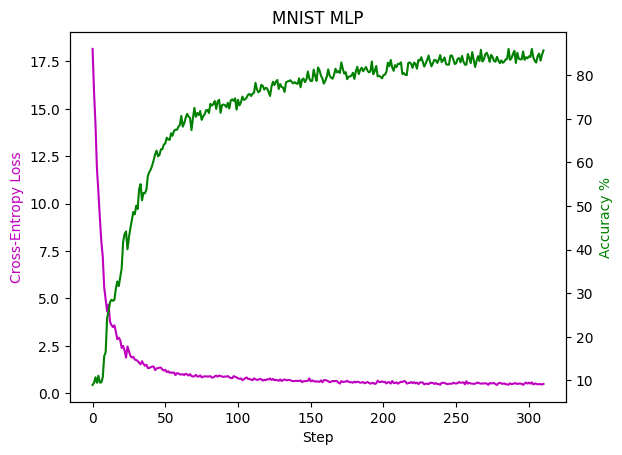

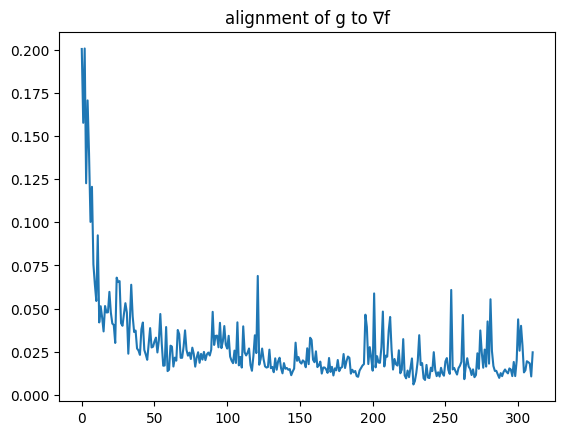

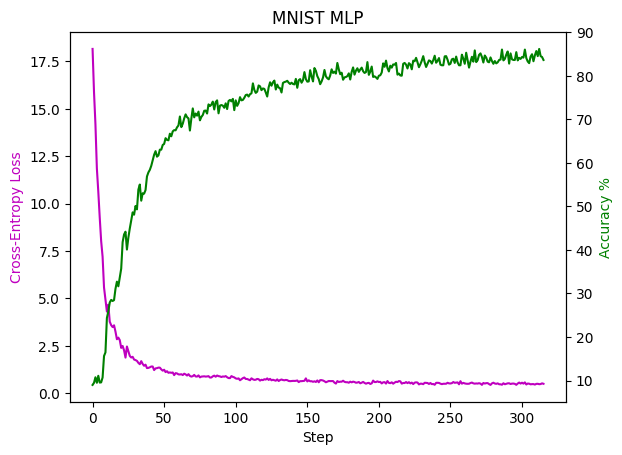

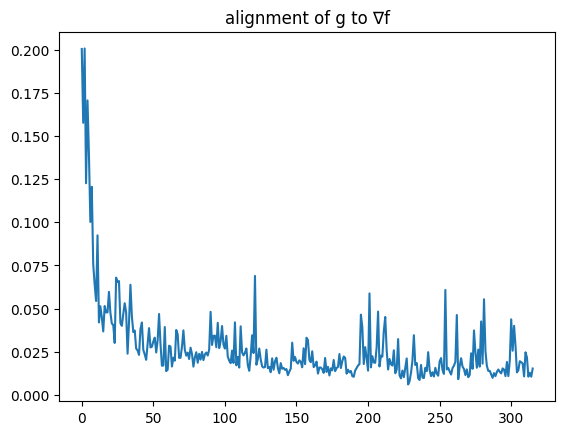

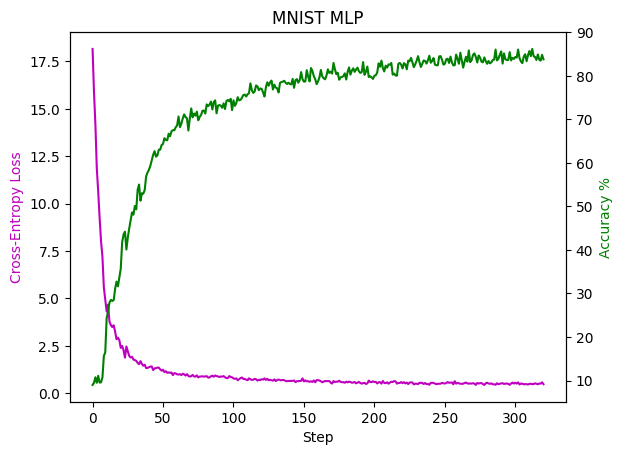

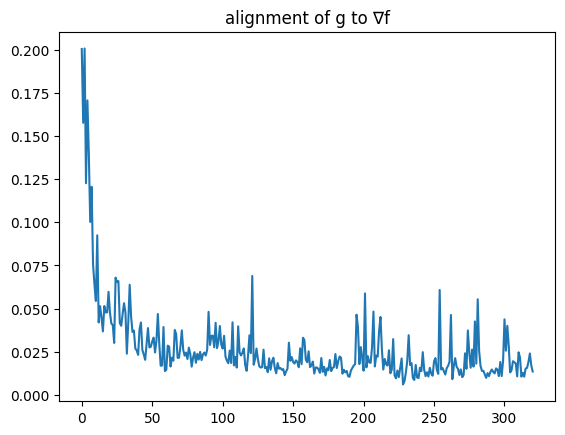

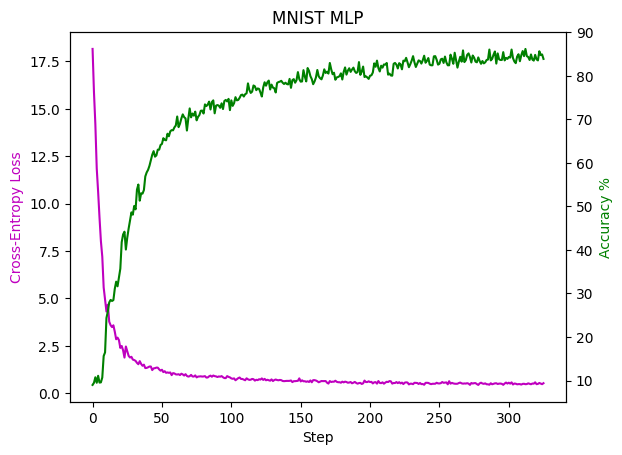

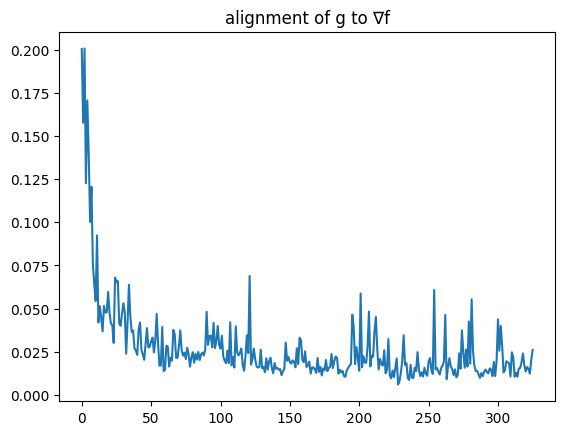

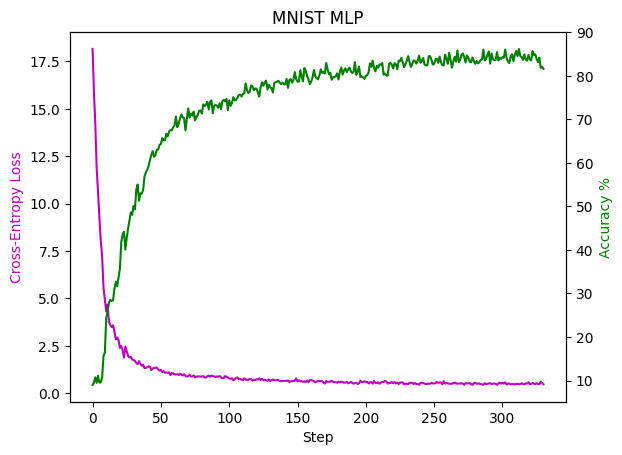

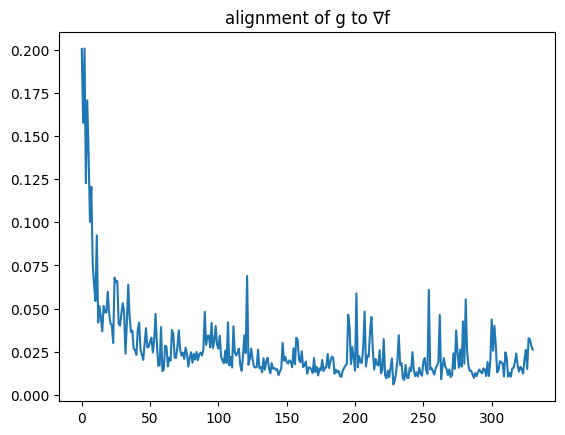

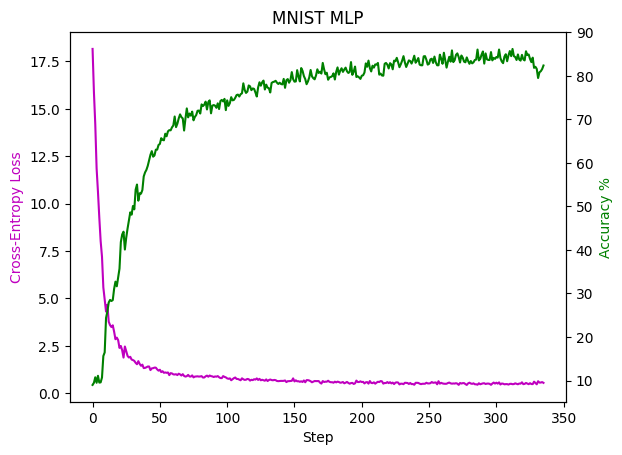

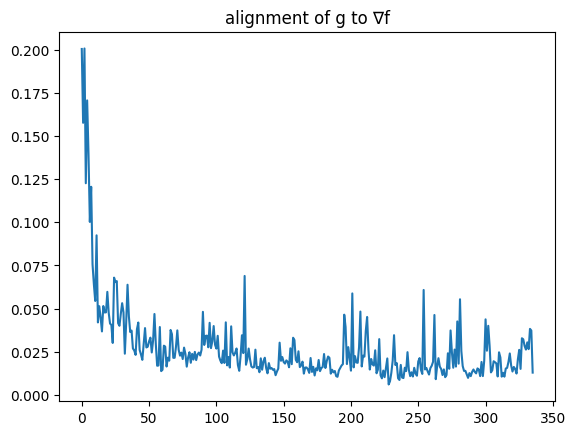

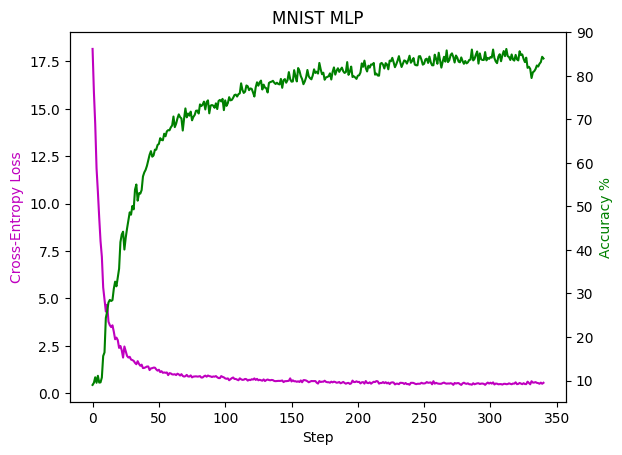

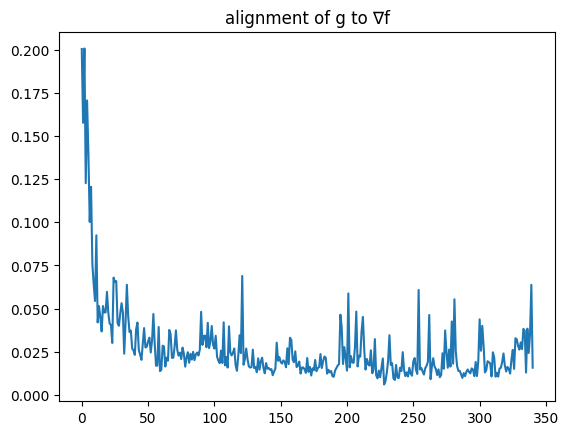

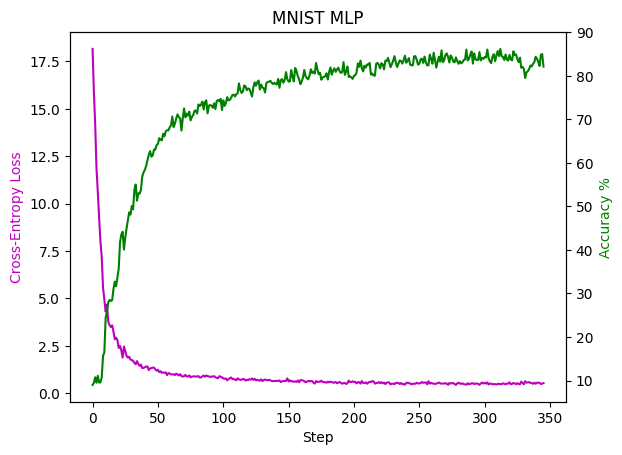

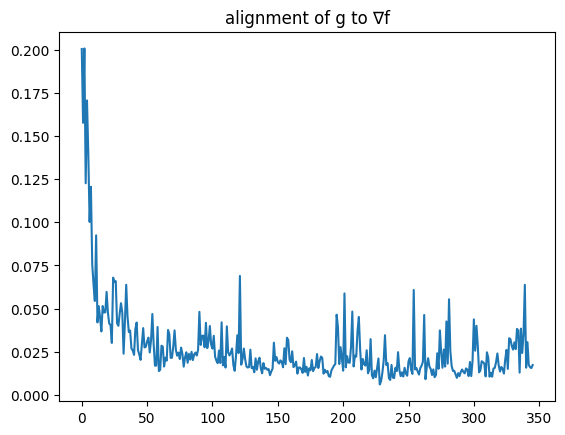

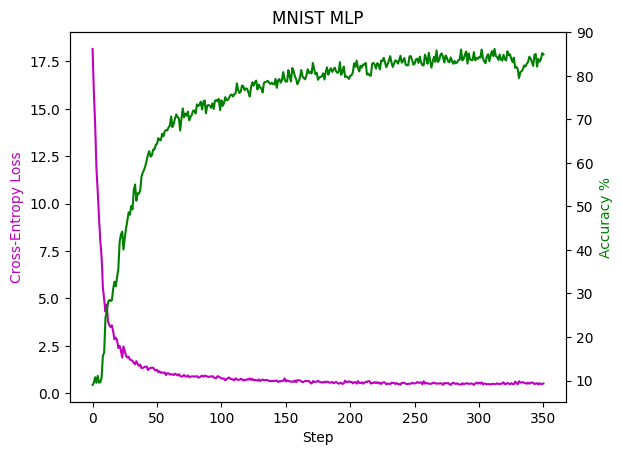

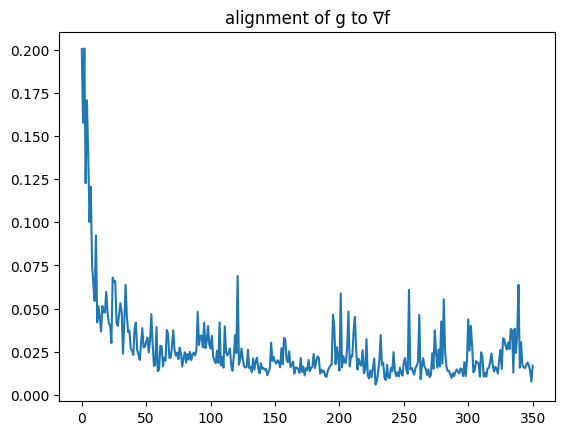

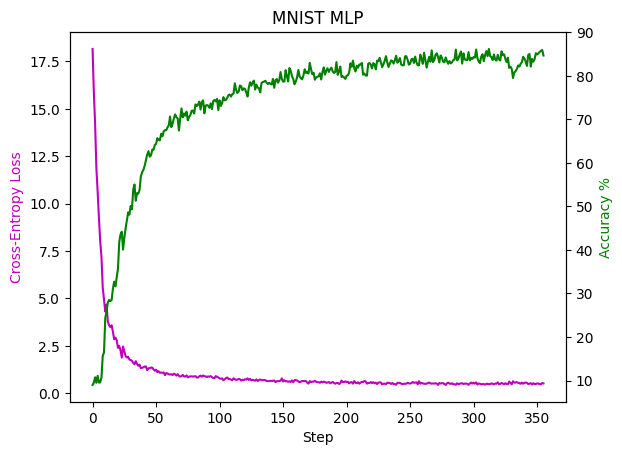

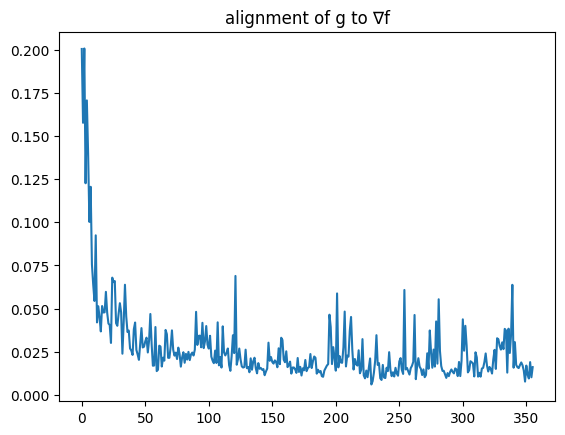

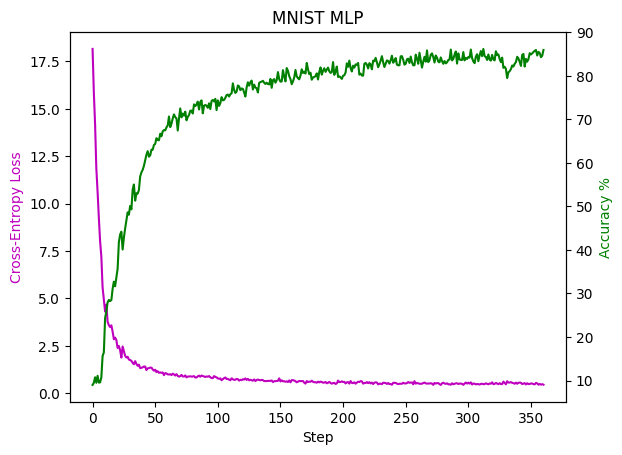

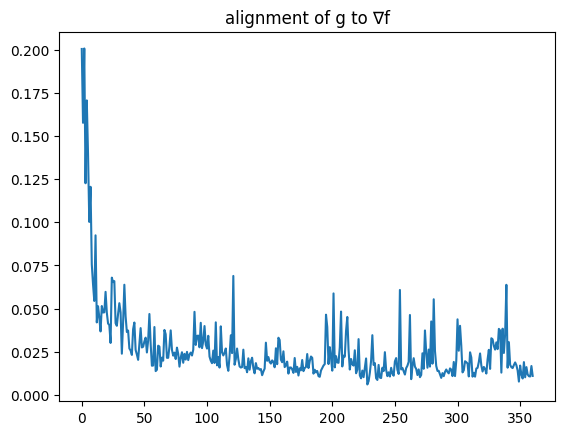

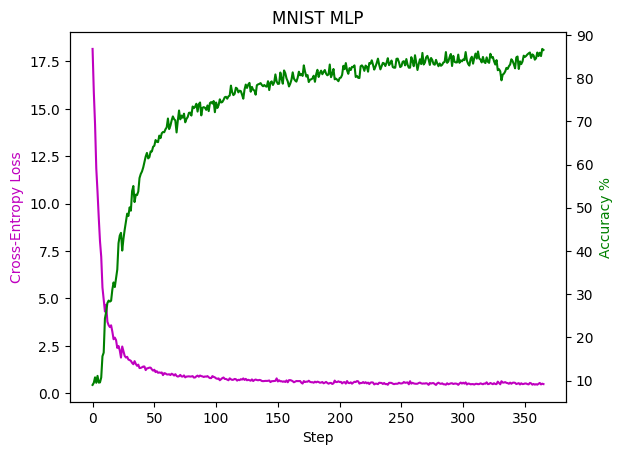

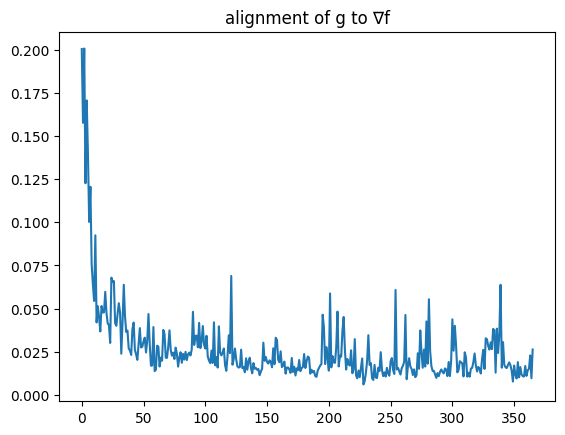

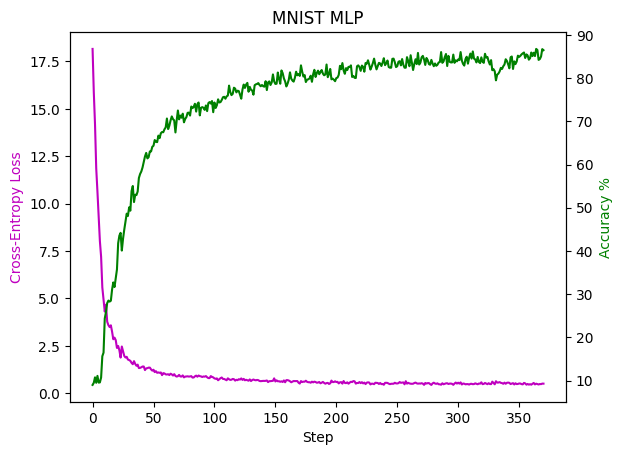

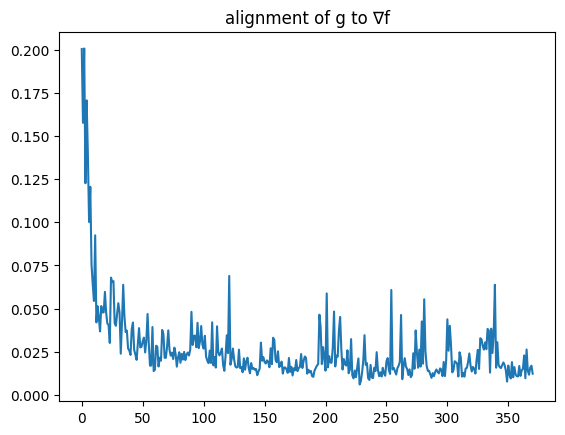

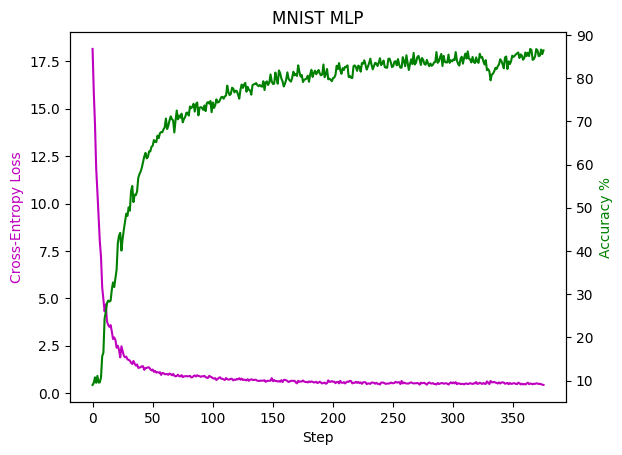

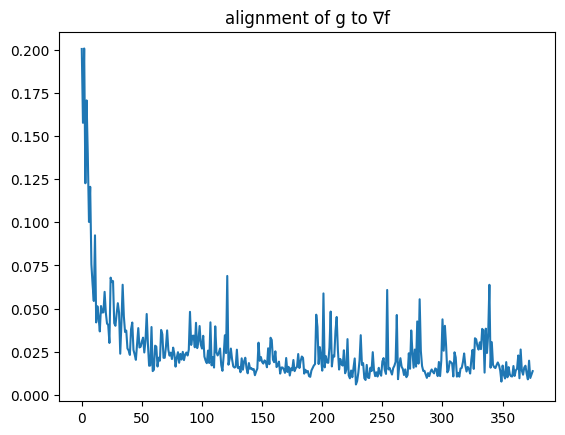

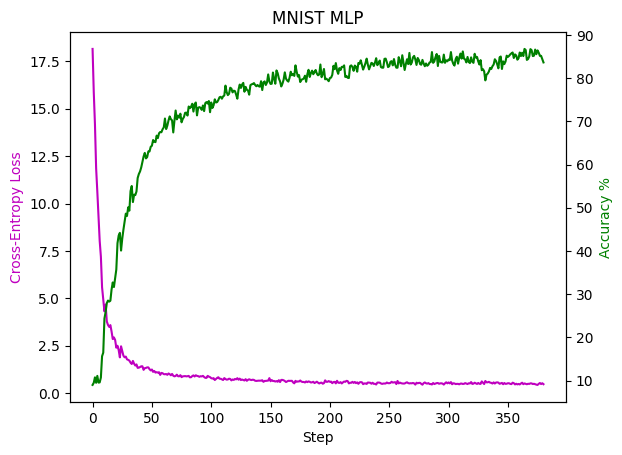

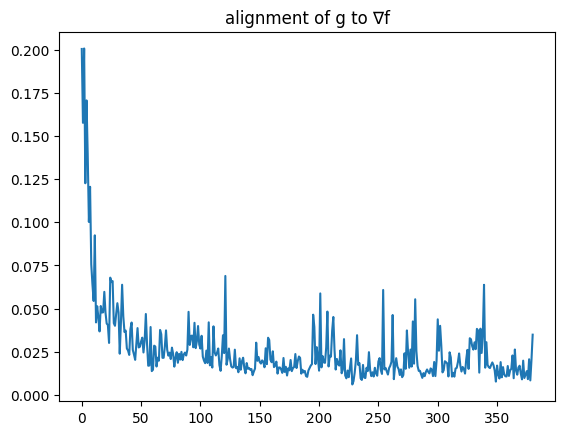

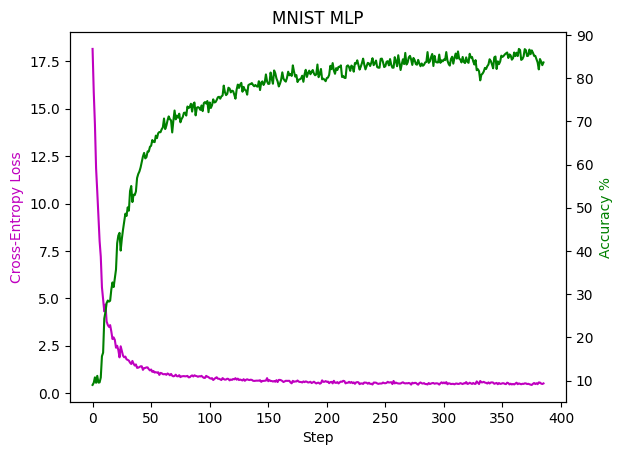

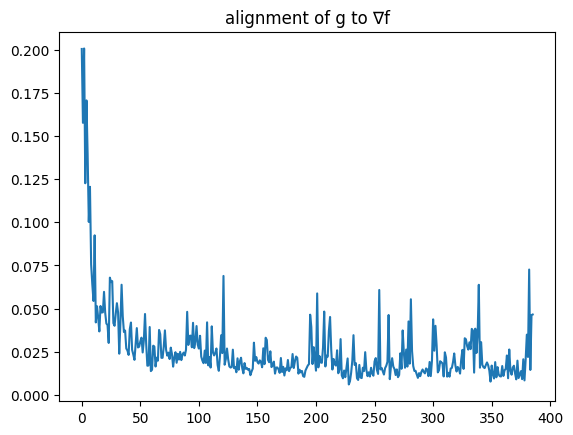

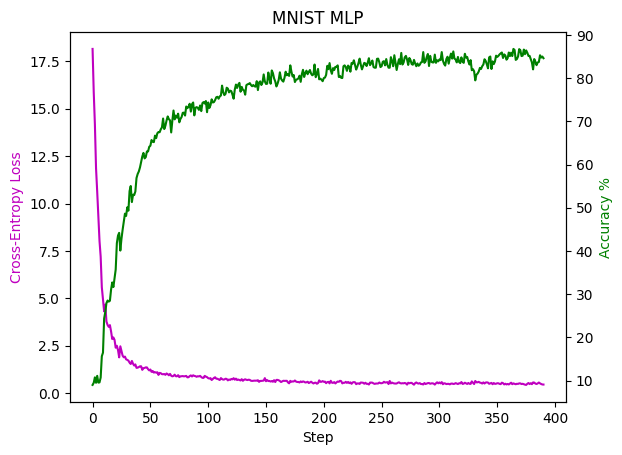

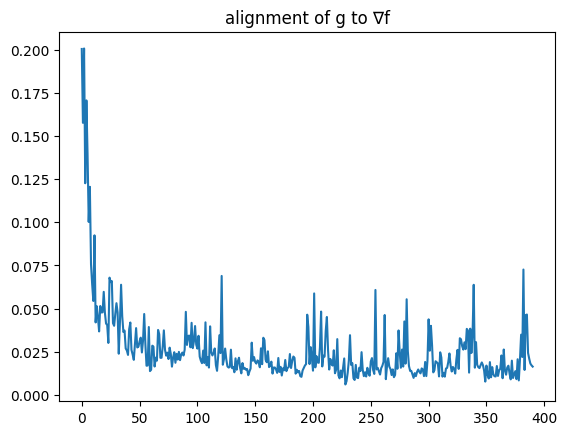

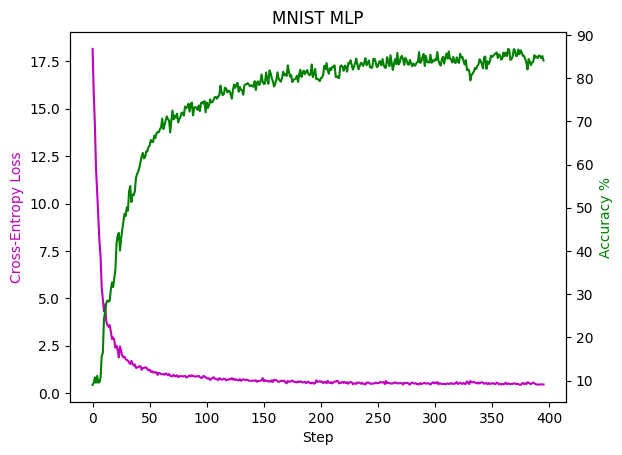

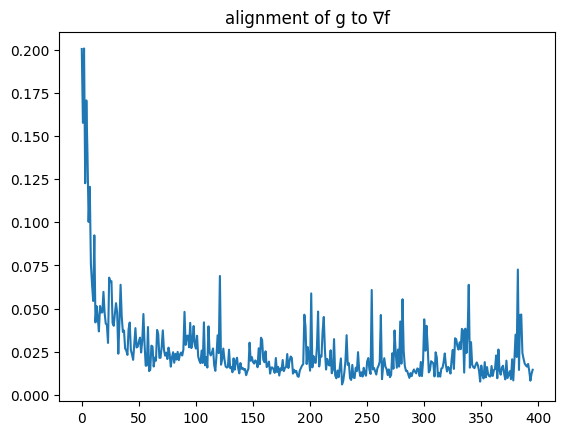

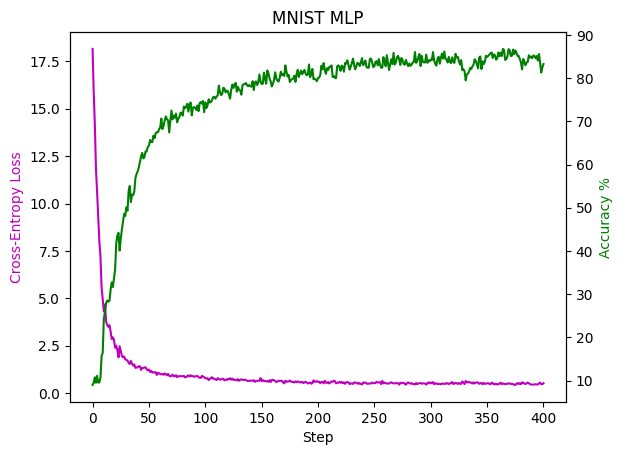

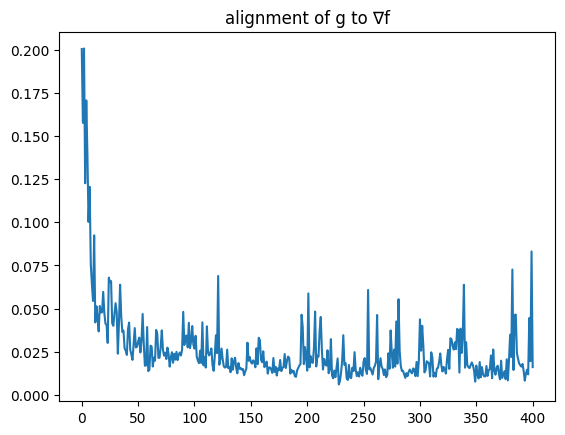

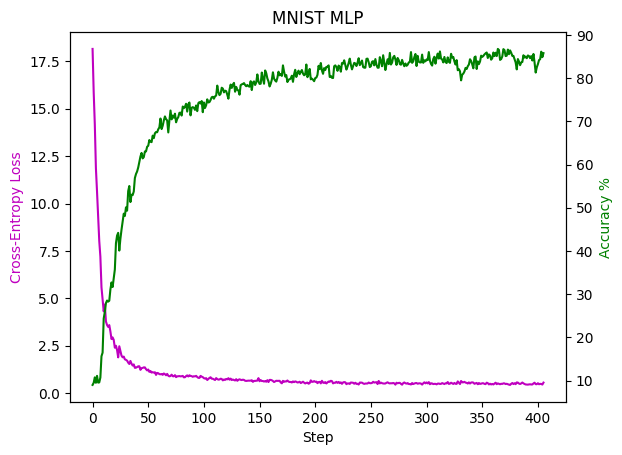

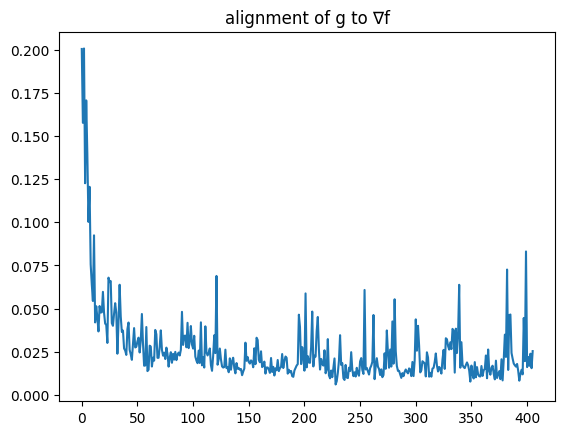

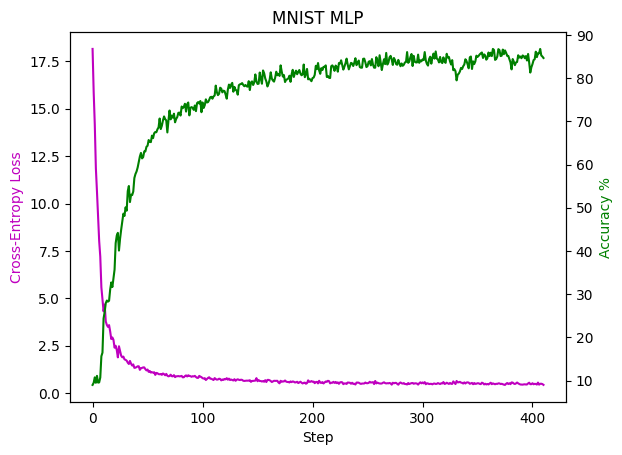

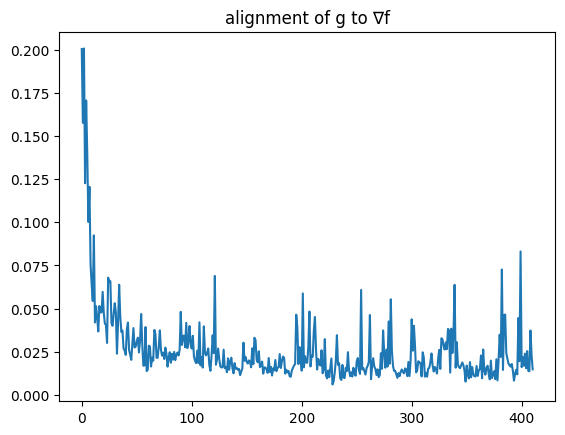

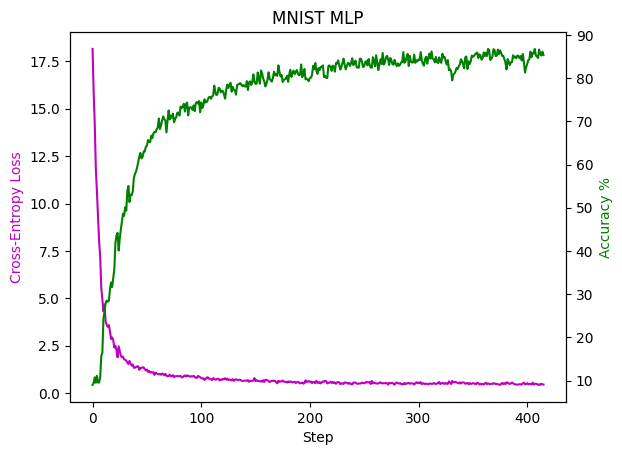

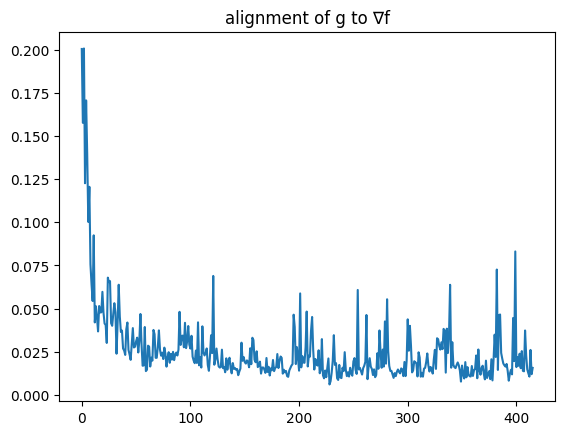

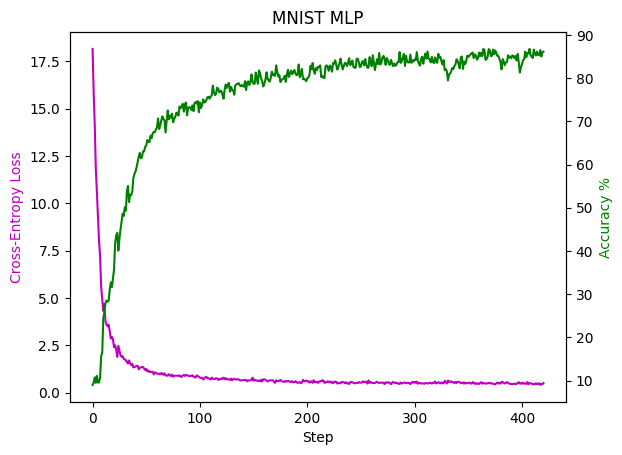

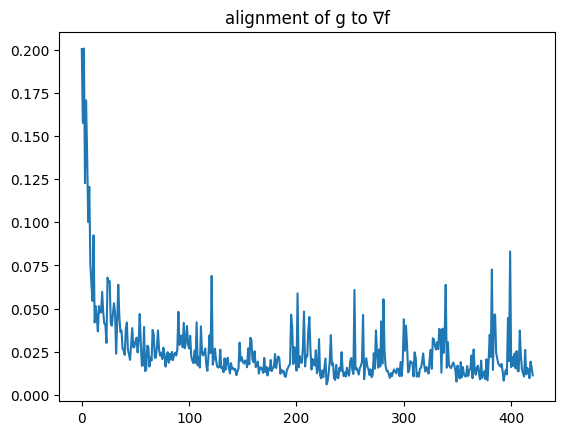

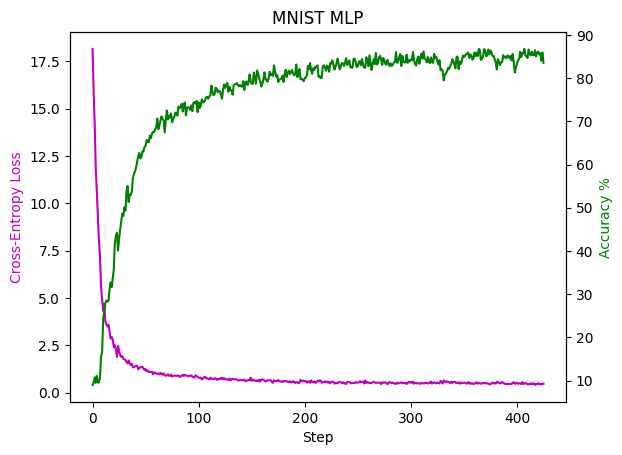

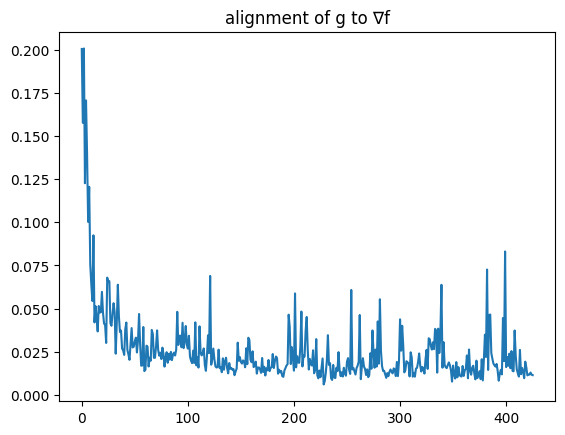

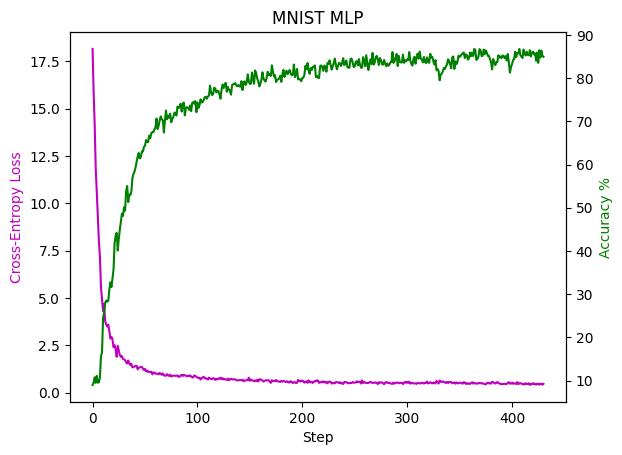

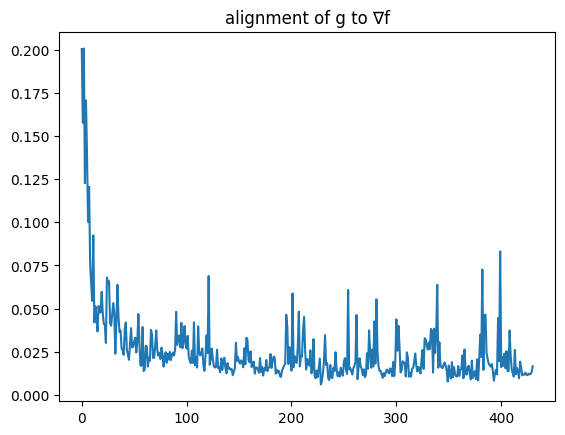

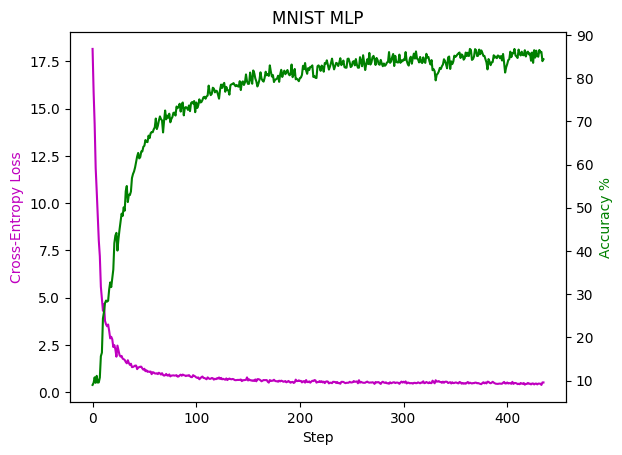

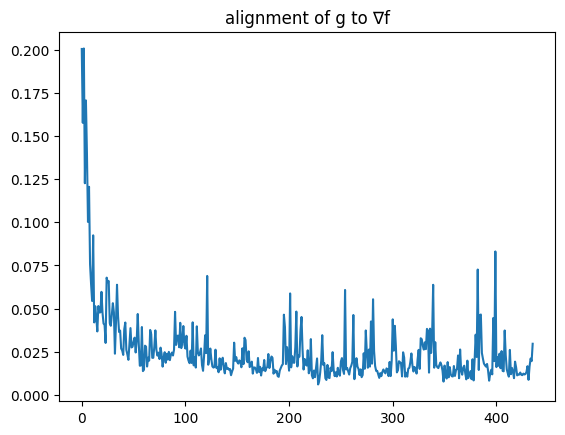

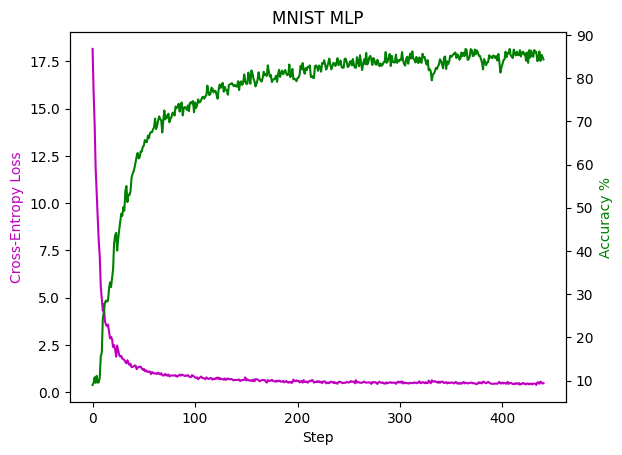

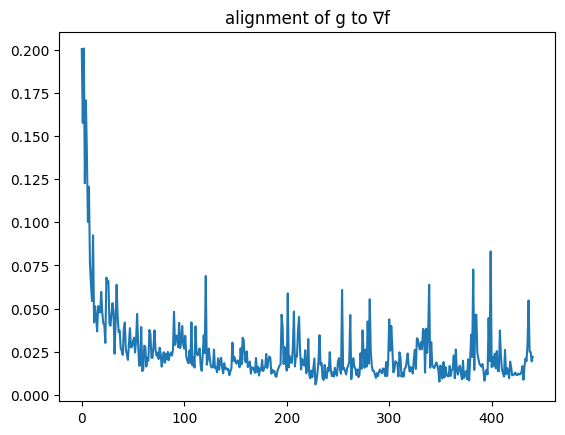

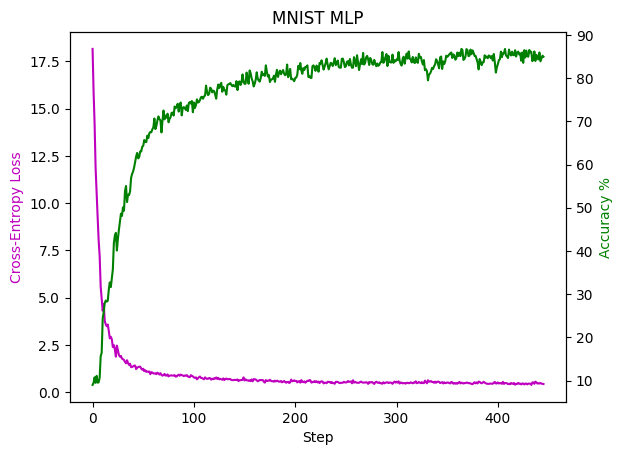

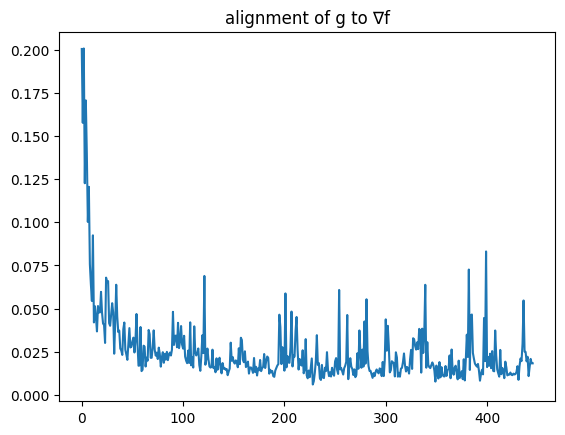

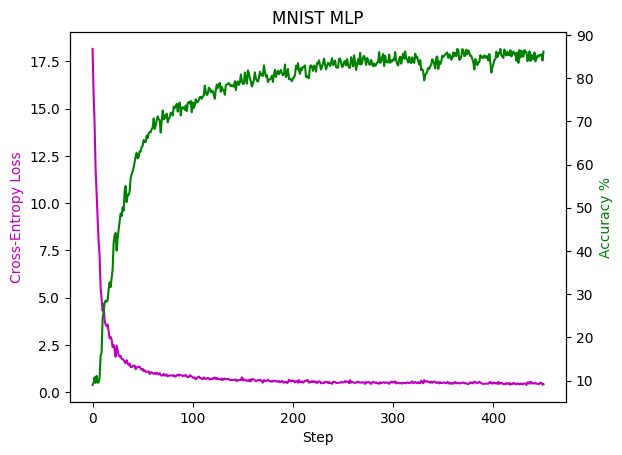

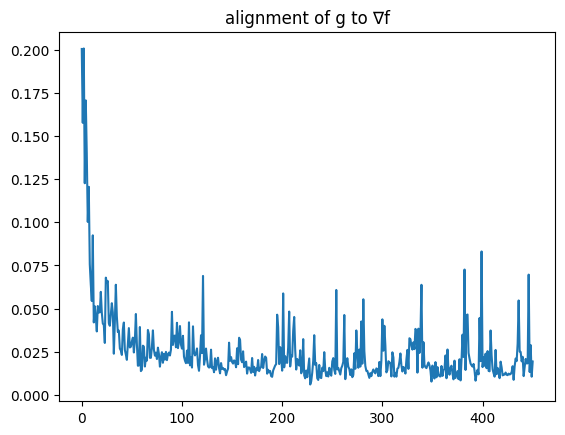

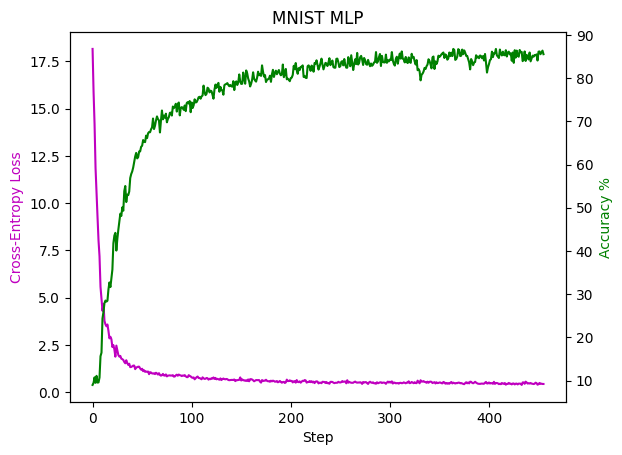

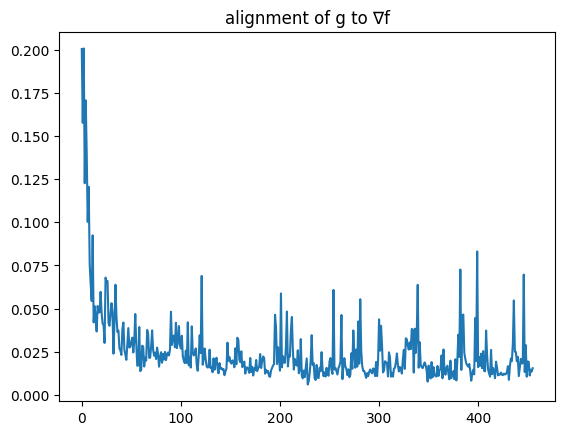

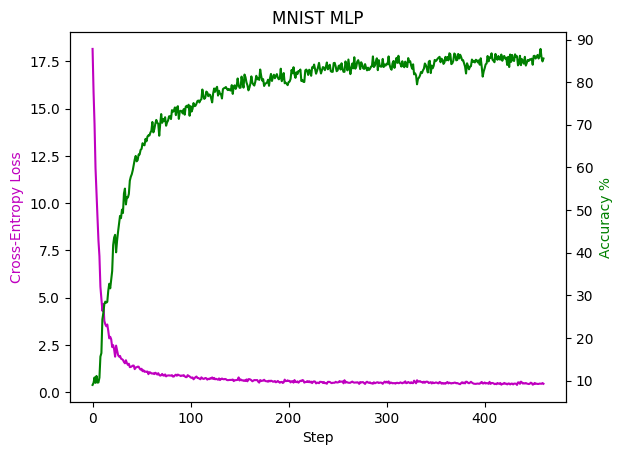

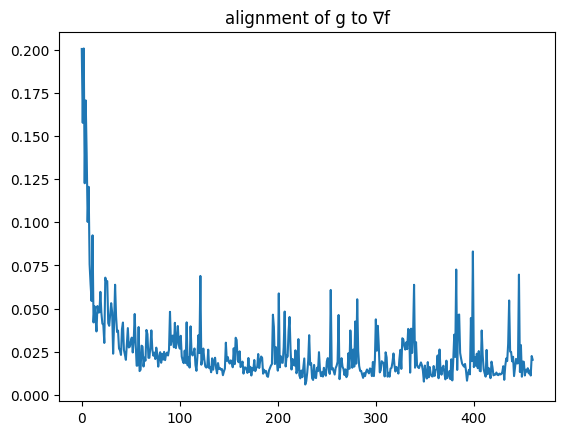

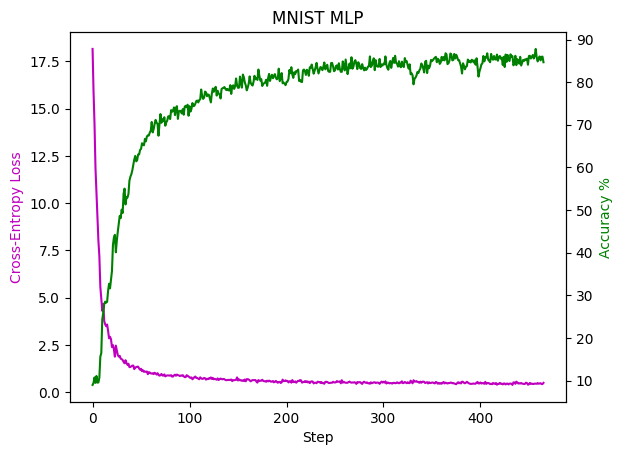

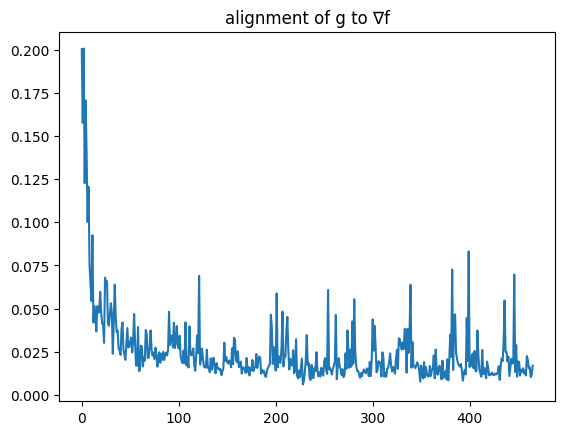

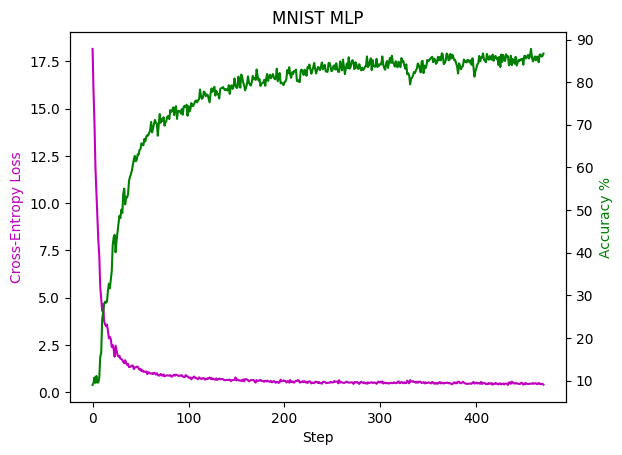

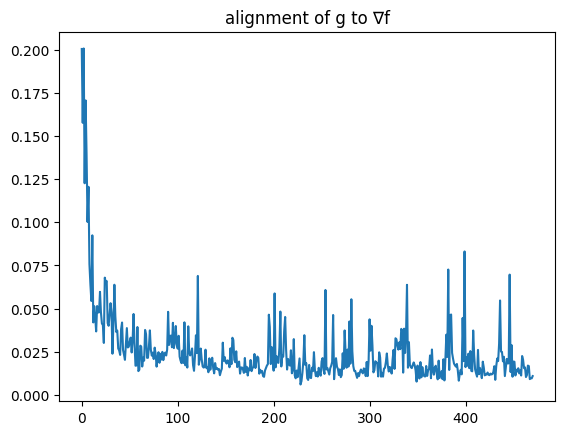

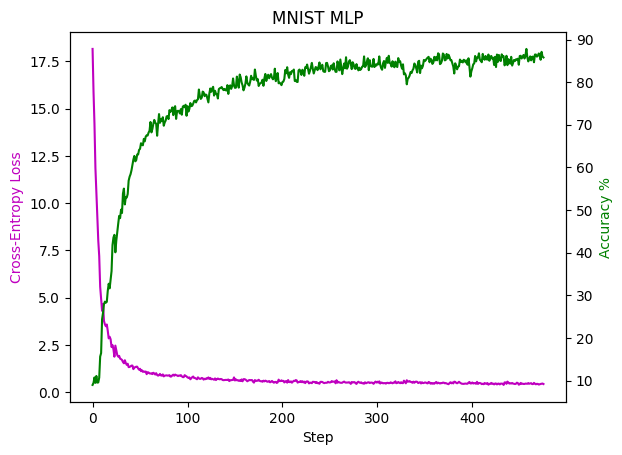

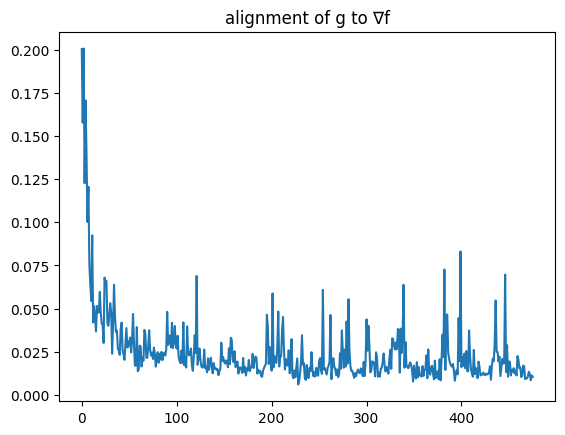

KeyboardInterrupt: 

In [8]:
batch_size = 1024
steps = 2000
input_size = 28*28
hidden_size = 256
output_size = 10

# ternary and precision dimensions
dim = total_params(input_size, hidden_size, output_size)

# init
theta = rand_tern((dim,))
samples = 128
noise_density = 16 / dim

loss_record = []
acc_record = []
align_record = []

print("problem dim:", dim)
print("uncompressed step size:", round(samples * math.log(3) / math.log(2), 3), "bits")

for j in range(steps):
  aligns = tch.zeros((samples))
  perturbs = tch.zeros((samples, dim,))

  batch = get_batch(batch_size)
  f = lambda t_theta: loss_fn(t_theta, batch, input_size, hidden_size, output_size)

  loss = 0.
  for k in range(0, samples):
    z = sign_noise((dim,)) * rand_mask((dim,), noise_density)
    perturbs[k,:] = z
    l, jvp = tch.func.jvp(f, (theta,), (z,))
    loss = l
    aligns[k] = jvp

  median = aligns.abs().median()
  align_terns = aligns.sign() * tch.where(aligns.abs() >= median, 1, 0)
  g = quant((perturbs * align_terns[:,None]).sum(axis=0))

  acc = compute_accuracy(theta, get_batch(2048), input_size, hidden_size, output_size)

  _, true_algn = tch.func.jvp(f,(theta,),(g,))
  true_algn /= dim * noise_density

  theta = quant(theta - g)

  loss_record.append(loss)
  acc_record.append(acc)
  align_record.append(true_algn)

  if j != 0 and j % 5 == 0:
    plot(loss_record, acc_record, align_record)

  if loss < 2:
    noise_density = 4 / dim
  if loss < 1:
    noise_density = 1 / dim
